In [1]:
import sys
import os
from typing import List
sys.path.append("..")

In [2]:
from collections import defaultdict
import os
import gzip
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from colour import Color

from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
from diachr.diachromatic_interaction_set import DiachromaticInteractionSet
from diachr.diachromatic_interaction import DiachromaticInteraction

### Implement DirectedTadVisualizer

In [9]:
class DirectedTadVisualizer:
    """
    This class coorrdinates the visualization of TADs, while showing directedness of interactions
    within each cell.
    """

    def __init__(self, i_file, t_file) -> None:
        if not isinstance(i_file, str) or not os.path.isfile(i_file):
            raise ValueError("Invalid file {}".format(i_file))
        self._fname = i_file
        
        self._figure_size = 10 # What does that mean?
        
        print('[INFO] Iitializing DirectedTadVisualizer object ...')
        
        print('\t[INFO] Reading interactions and group them by chromosomes ...')
        self._d_inter_by_chrom_dict = dict()
        d_inter_set = DiachromaticInteractionSet(rpc_rule = 'ht')
        d_inter_set.parse_file(i_file = i_file, verbose = False)
        for d_inter in d_inter_set.interaction_list:
            if d_inter.chrA == d_inter.chrB:
                if d_inter.chrA not in self._d_inter_by_chrom_dict:
                    self._d_inter_by_chrom_dict[d_inter.chrA] = [d_inter]
                else:
                    self._d_inter_by_chrom_dict[d_inter.chrA].append(d_inter)                    
        #for key, d_inter_list in self._d_inter_by_chrom_dict.items():
            #print('\t' + key + ': ' + '{:,}'.format(len(d_inter_list)) + ' interactions')
        print('\t[INFO] ... done.')
        
        print('\t[INFO] Reading TAD regions and group them by chromosomes ...')
        self._tads_by_chrom_dict = dict()
        with open(t_file, 'rt') as fp:
            next(fp)
            for line in fp:
                c, s, e = line.rstrip().split('\t')
                
                if c not in self._tads_by_chrom_dict:
                    self._tads_by_chrom_dict[c] = [(int(s), int(e))]
                else:
                    self._tads_by_chrom_dict[c].append((int(s), int(e)))
        #for key, tad_list in self._tads_by_chrom_dict.items():
            #print('\t' + key + ': ' + '{:,}'.format(len(tad_list)) + ' TADs')
        print('\t[INFO] ... done.')
        print('[INFO] ... done.')
        

    def extract_interactions(self, chrom, begin, end):
        """
        Create reduced interaction list that only contains interactions within the region to be visualized.
        """
        
        # Check arguments
        if not isinstance(chrom, str):
            raise ValueError("chrom must be a string")
        if not isinstance(begin, int) or not isinstance(end, int):
            raise ValueError("begin and end must be integers")
        
        # If there are no interactions for this chromosome, return empty list
        if chrom not in self._d_inter_by_chrom_dict:
            return inter_list
            
        # Extract interactions
        inter_list = []
        for d_inter in self._d_inter_by_chrom_dict[chrom]:
            
            # Only keep interactions completely within the region we want to visualize
            if d_inter.chrA == chrom and begin < d_inter.fromA and d_inter.toB < end:
                inter_list.append(d_inter)
            
        print("[INFO] Extracted {} interactions in range {}:{}-{}".format(len(inter_list), chrom, begin, end))      
        return inter_list

    def pos_to_coordinate(self, pos):
        """
        Convert genomic position to plot coordinate.
        """
        return (pos - self._min) * self._factor
        
    def coordinate_to_pos(self, coordinate):
        """
        Convert plot coordinate to genomic position.
        """
        return coordinate/self._factor + self._min
    
    def tad_to_grey_triangle(self, start:int, end:int) -> PolygonPatch:
        begin = self.pos_to_coordinate(start) 
        end = self.pos_to_coordinate(end)
        TANGENT_45 = math.tan(math.pi / 4)
        # bc is the point where lines from b and c meet
        midpoint_x = begin + 0.5 * (end - begin)
        # bc is the length of the segment from b to bc_x
        bc = midpoint_x - begin
        # tan = opposite/adjacent
        # opposite = tan(45)*adjacent
        bc_y = TANGENT_45 * bc
        poly = Polygon([(begin, 0), (midpoint_x, bc), (end, 0)])
        color = 'gray'
        return PolygonPatch(polygon=poly, color=color, alpha=0.25)
    
    def black_triangle_left(self, start:int, end:int):
        begin = self.pos_to_coordinate(start) 
        end = self.pos_to_coordinate(end)
        midpoint_x = begin + 0.5 * (end - begin)
        bc = midpoint_x - begin
        poly = Polygon([(begin, 0), (begin, bc), (midpoint_x, bc)])
        color = 'black'
        return PolygonPatch(polygon=poly, color=color)
    
    def black_triangle_right(self, start:int, end:int):
        begin = self.pos_to_coordinate(start) 
        end = self.pos_to_coordinate(end)
        midpoint_x = begin + 0.5 * (end - begin)
        bc = midpoint_x - begin
        poly = Polygon([(midpoint_x, bc), (end, bc), (end, 0)])
        color = 'black'
        return PolygonPatch(polygon=poly, color=color)
    
    def interaction_to_polygon(self, d_inter, pp_color, pp_alpha):
        """
        Creates a PolygonPatch for a given interaction.
        """
        if not isinstance(d_inter, DiachromaticInteraction):
            raise ValueError("Not a DiachromaticInteraction")
        
        TANGENT_45 = math.tan(math.pi / 4)  # The lines go up at 45 degree angles
        # a,b,c,d are coordinates of the two digests on the X axis
        a = self.pos_to_coordinate(d_inter.fromA)
        b = self.pos_to_coordinate(d_inter.toA)
        c = self.pos_to_coordinate(d_inter.fromB)
        d = self.pos_to_coordinate(d_inter.toB)
        # bc is the point where lines from b and c meet
        bc_x = b + 0.5 * (c - b)
        # bc is the length of the segment from b to bc_x
        bc = bc_x - b
        # tan = opposite/adjacent
        # opposite = tan(45)*adjacent
        bc_y = TANGENT_45 * bc
        # ad is the point where lines from a and d meet
        ad_x = a + 0.5 * (d - a)
        ad = ad_x - a
        ad_y = TANGENT_45 * ad
        # ac is the point where lines from a and c meet
        ac_x = a + 0.5 * (c - a)
        ac = ac_x - a
        ac_y = TANGENT_45 * ac
        # bd is the point where lines from b and d meet
        bd_x = b + 0.5 * (d - b)
        bd = bd_x - b
        bd_y = TANGENT_45 * bd
        poly = Polygon([(bc_x, bc_y), (bd_x, bd_y), (ad_x, ad_y), (ac_x, ac_y)])
        
        return PolygonPatch(polygon=poly, color=pp_color, alpha=pp_alpha)
    

    def create_visualization(self,
                             chrom:str,
                             begin:int,
                             end:int,
                             inter_cat_list:List,
                             enr_cat_list:List,
                             color_i_cats = True):
        """
        Create a TADviz plot.
        """
        
        i_cat_colors = {
            'DIX': 'orangered',
            'DI': 'orange',
            'UIR': 'green',
            'UI': 'gray'
        }
            
        ht_tag_colors = {
            '01': 'pink',
            '02': 'red',
            '03': 'lime',
            '12': 'magenta',
            '13': 'blue',
            '23': 'turquoise'
        }
        
        figure_height = 8
        figure_width = 2 * figure_height
        
        # Get list of interactions completely within the region to be visualized
        inter_list = self.extract_interactions(chrom=chrom,
                                               begin=begin,
                                               end=end)
        
        # If there are no interaction within this region, do nothing
        if len(inter_list) == 0:
            return
        
        # Get TAD regions for this chromosome
        tads = self._tads_by_chrom_dict[chrom]
            
        # Get list of interactions and set of digests
        d_inter_list = []
        rp_total_list = []
        max_i_dist = 0
        for d_inter in inter_list:
            if d_inter.get_category() in inter_cat_list: # Filter for interaction category
                d_inter_list.append(d_inter)
                if max_i_dist < d_inter.i_dist:
                    max_i_dist = d_inter.i_dist
                rp_total_list.append(d_inter.rp_total) #(for all interactions or visualized interactions only?)
        
        # Determine read pair counts for quantiles 0.1, ..., 1.0
        quantile_range = np.arange(0.1,1.1,0.1)         
        quantile_values = np.quantile(rp_total_list, quantile_range)
        print('[INFO] Read pair count quantiles:')
        print('\t[INFO] ' + str(quantile_values))
        print('\t[INFO] ' + str(str(quantile_range)))
        
        # Get scaling factor
        self._min = begin
        self._max = end     
        self._span = end - begin
        self._factor = self._figure_size / self._span
                               
        print("[INFO] Got {} interactions".format(len(d_inter_list)))       
        print('[INFO] begin: ' + str(begin))
        print('[INFO] end: ' + str(end))
        print('[INFO] pos_to_coordinate(begin): ' + str(self.pos_to_coordinate(begin)))
        print('[INFO] pos_to_coordinate(end): ' + str(self.pos_to_coordinate(end)))
        print('[INFO] coordinate_to_pos(pos_to_coordinate(begin)): ' + str(self.coordinate_to_pos(self.pos_to_coordinate(begin))))
        print('[INFO] coordinate_to_pos(pos_to_coordinate(end)): ' + str(self.coordinate_to_pos(self.pos_to_coordinate(end))))
        
        # Created figure
        fig = plt.figure(1, figsize=(figure_width, figure_height))
        ax = fig.add_subplot(111)
        
        ax.set_title(str(inter_cat_list) + str(enr_cat_list), loc='left', fontsize='x-large')
        ax.set_xlabel('Genomic coordinate', labelpad=12, fontsize='x-large')
        ax.set_ylabel('Interaction distance', labelpad=12, fontsize='x-large')
               
        # Set limits of x and y axes
        xrange = [self.pos_to_coordinate(begin), self.pos_to_coordinate(end)]
        yrange = [0, 0.5 * (self.pos_to_coordinate(end) - self.pos_to_coordinate(begin))]
        # Uncomment the following line in order to set the upper ylim to the maximum interaction distance
        #yrange = [0, 0.5 * (self.pos_to_coordinate(2*max_i_dist) - self.pos_to_coordinate(max_i_dist))]
        ax.set_xlim(xrange)
        ax.set_ylim(yrange)
        
        ## Plot the TADs
        for (left_boundary, right_boundary) in tads:
            polypatch = self.tad_to_grey_triangle(start=left_boundary, end=right_boundary)
            ax.add_patch(polypatch)
                       
       # Plot the interaction polygons
        for d_inter in d_inter_list:
            i_cat = d_inter.get_category()
            e_cat = d_inter.enrichment_status_tag_pair
            if i_cat in inter_cat_list and e_cat in enr_cat_list:
                
                # Determine transparency depending on read pair count
                i = 1
                pp_alpha = 0.0
                for i in range(0, 10):
                    if quantile_values[i] < d_inter.rp_total:
                        pp_alpha = quantile_range[i]
                #print(str(d_inter.rp_total) + '\t' + str(pp_alpha))
                        
                # Choose color depending on the interaction category or ht_tag
                if color_i_cats:
                    pp_color = i_cat_colors[i_cat]
                else:
                    pp_color = ht_tag_colors[d_inter.get_ht_tag()]

                    
                # Get and plot interaction polypatch
                polypatch = self.interaction_to_polygon(d_inter=d_inter,
                                                        pp_color=pp_color,
                                                        pp_alpha=pp_alpha)                
                ax.add_patch(polypatch)
                
        # Plot black triangles
        polypatch = self.black_triangle_left(start=begin, end=end)
        ax.add_patch(polypatch)
        polypatch = self.black_triangle_right(start=begin, end=end)
        ax.add_patch(polypatch)
        
        # Add genomic coordinate labels to x-axis
        ax.set_xticks(ax.get_xticks())
        xtick_labels = ['{:,}'.format(round(self.coordinate_to_pos(x))) for x in ax.get_xticks()]
        ax.set_xticklabels(xtick_labels)
        
        # Add interaction distance labels to y-axis (correct?)
        ax.set_yticks(ax.get_yticks())
        ytick_labels = ['{:,}'.format(2*round(visualizer.coordinate_to_pos(y) - begin)) for y in ax.get_yticks()]
        ytick_labels[0] = ''
        ax.set_yticklabels(ytick_labels)
        
        
        ax.set_aspect(1) # What does that do?
        plt.show()


## Initialize ``DirectedTadVisualizer``

In [4]:
#INTERACTION_FILE = '/Users/robinp/Downloads/JAV_MK_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'
#INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR005/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'

# Large files
#INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR005/CHC/JAV_MK_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions_chr10.tsv.gz'
#INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR001/CHC/JAV_MK_RALT_20000_ht_fdr0.01_evaluated_and_categorized_interactions.tsv.gz'

# Small files for chromosome 'chr10' only
#INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR005/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions_chr10.tsv.gz'
INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR001/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.01_evaluated_and_categorized_interactions_chr10.tsv.gz'

CELL_TYPE_SHORT = 'MK'
TAD_BED_FILE = '../additional_files/javierre_2016/tad_regions_hg38/hglft_genome_TADs_' + CELL_TYPE_SHORT + '_hg38.bed'
TAD_BED_FILE = '../additional_files/javierre_2016/tad_regions_hg38/all_tad_regions.bed'

#INTERACTION_FILE_1 = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR001/CHC/JAV_MK_RALT_20000_ht_fdr0.01_evaluated_and_categorized_interactions.tsv.gz'
#INTERACTION_FILE_2 = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR001/CHC/JAV_NB_RALT_20000_ht_fdr0.01_evaluated_and_categorized_interactions.tsv.gz'




In [10]:
visualizer = DirectedTadVisualizer(i_file=INTERACTION_FILE, t_file=TAD_BED_FILE)

[INFO] Iitializing DirectedTadVisualizer object ...
	[INFO] Reading interactions and group them by chromosomes ...
	[INFO] ... done.
	[INFO] Reading TAD regions and group them by chromosomes ...
	[INFO] ... done.
[INFO] ... done.


## Create visualizations

### Compare interaction categories for one cell type in a specific region

[INFO] Extracted 14520 interactions in range chr10:10503000-15503000
[INFO] Read pair count quantiles:
	[INFO] [  47.   57.   70.   83.  100.  120.  143.  175.  238. 1003.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10503000 max: 15503000
[INFO] Got 1667 interactions
[INFO] begin: 10503000
[INFO] end: 15503000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10503000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15503000.0


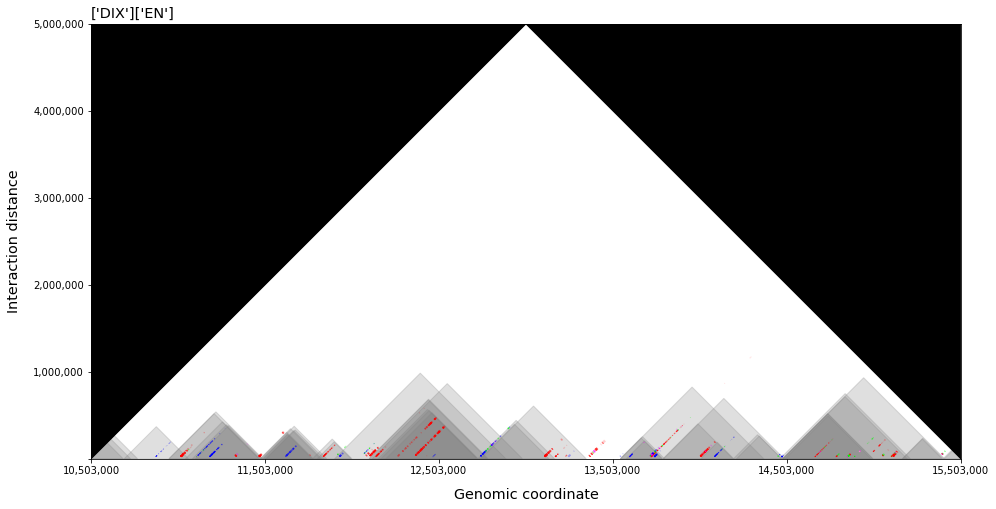

[INFO] Extracted 14520 interactions in range chr10:10503000-15503000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  21.  26.  33.  45.  70. 694.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10503000 max: 15503000
[INFO] Got 5759 interactions
[INFO] begin: 10503000
[INFO] end: 15503000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10503000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15503000.0


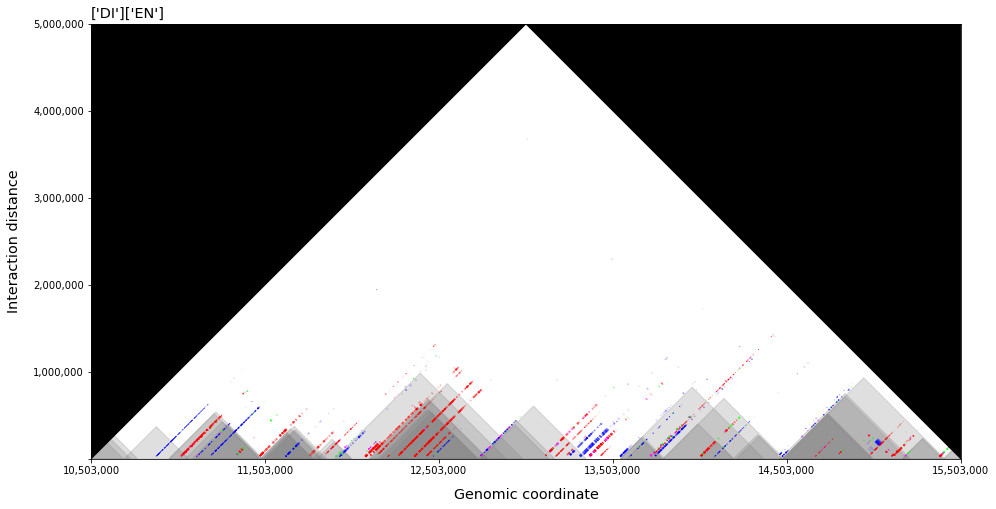

[INFO] Extracted 14520 interactions in range chr10:10503000-15503000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  23.  29.  38.  58. 528.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10503000 max: 15503000
[INFO] Got 4395 interactions
[INFO] begin: 10503000
[INFO] end: 15503000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10503000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15503000.0


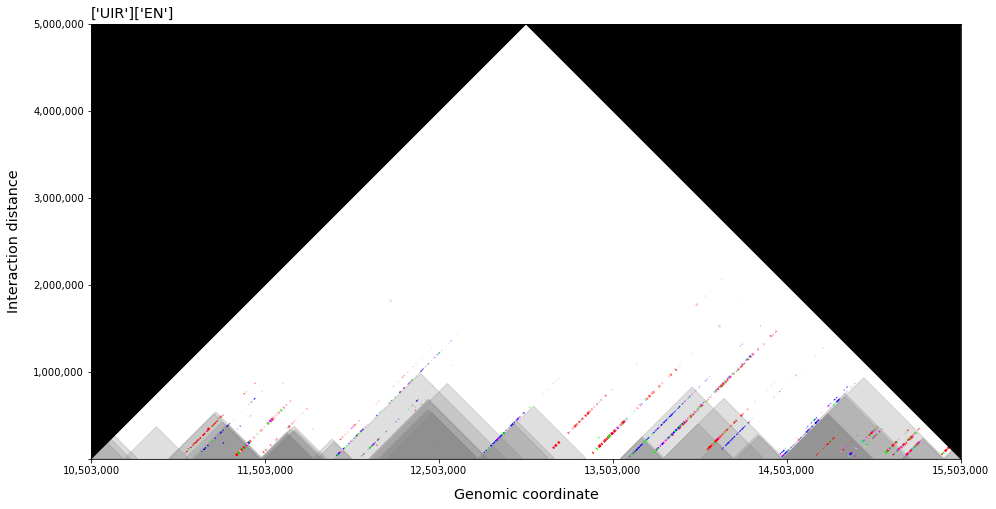

[INFO] Extracted 14520 interactions in range chr10:10503000-15503000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 12. 13. 14. 17. 29.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10503000 max: 15503000
[INFO] Got 2699 interactions
[INFO] begin: 10503000
[INFO] end: 15503000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10503000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15503000.0


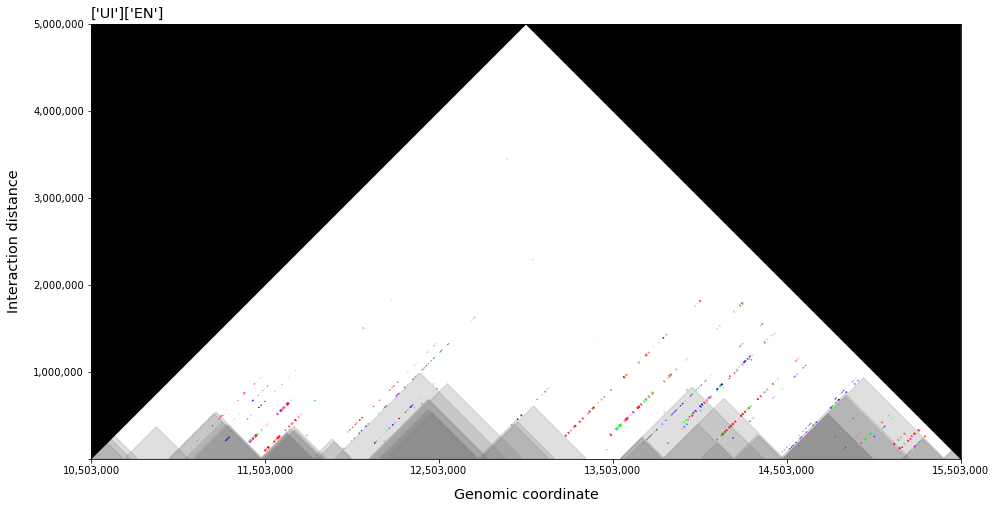

In [11]:
chrom = 'chr10'
begin = 10503000
end = begin + 5000000
for i_cat in ['DIX','DI','UIR','UI']:
    visualizer.create_visualization(chrom = chrom,
                                    begin = begin,
                                    end = end,
                                    inter_cat_list = [i_cat],
                                    enr_cat_list = ['EN'],
                                    color_i_cats = False)

[INFO] Extracted 14520 interactions in range chr10:10503000-15503000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  21.  26.  33.  45.  70. 694.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
2e-06
[INFO] min: 10503000 max: 15503000
[INFO] Got 5759 interactions
[INFO] begin: 10503000
[INFO] end: 15503000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10503000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15503000.0


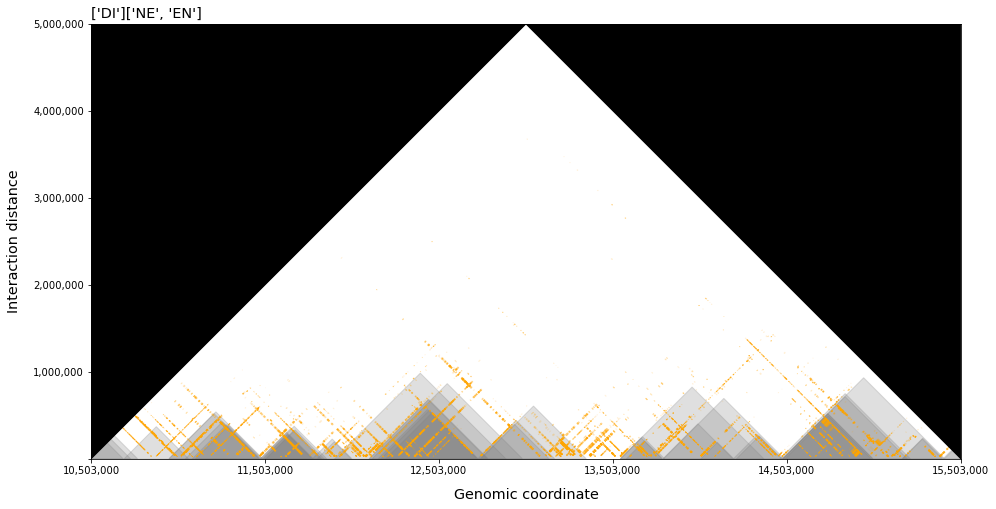

In [7]:
chrom = 'chr10'
begin = 10503000
end = begin + 5000000
visualizer.create_visualization(chrom = chrom,
                                begin = begin,
                                end = end,
                                inter_cat_list = ['DI'],
                                enr_cat_list = ['NE','EN'],
                                color_i_cats = True)

[INFO] Extracted 14520 interactions in range chr10:10503000-15503000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  23.  29.  38.  58. 528.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
2e-06
[INFO] min: 10503000 max: 15503000
[INFO] Got 4395 interactions
[INFO] begin: 10503000
[INFO] end: 15503000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10503000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15503000.0


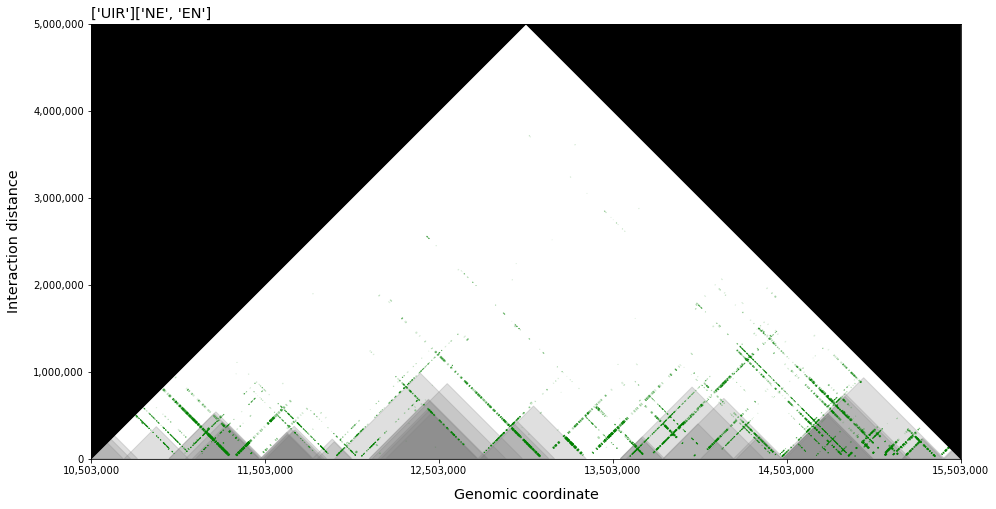

In [23]:
chrom = 'chr10'
begin = 10503000
end = begin + 5000000
visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat_list=['UIR'],
                                enr_cat_list=['NE','EN'],
                                color_i_cats = True)

[INFO] Extracted 14520 interactions in range chr10:10503000-15503000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 12. 13. 14. 17. 29.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
2e-06
[INFO] min: 10503000 max: 15503000
[INFO] Got 2699 interactions
[INFO] begin: 10503000
[INFO] end: 15503000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10503000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15503000.0


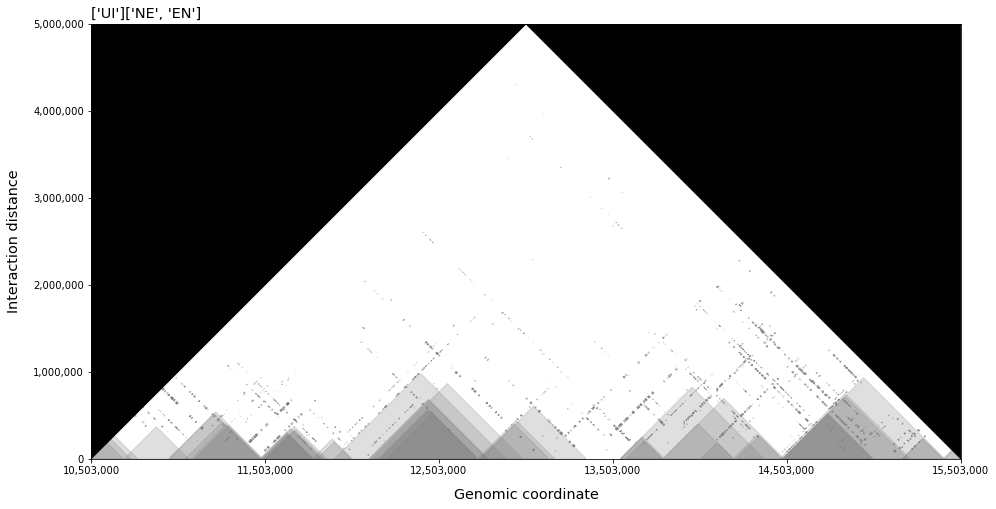

In [24]:
chrom = 'chr10'
begin = 10503000
end = begin + 5000000
visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat_list=['UI'],
                                enr_cat_list=['NE','EN'],
                                color_i_cats = True)

[INFO] Extracted 3169 interactions in range chr1:5000000-7500000
[INFO] Read pair count quantiles:
	[INFO] [  49.5   59.    71.    79.   100.5  117.   143.   178.   263.  1147. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 5000000 max: 7500000
[INFO] Got 366 interactions
[INFO] begin: 5000000
[INFO] end: 7500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 5000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 7500000.0


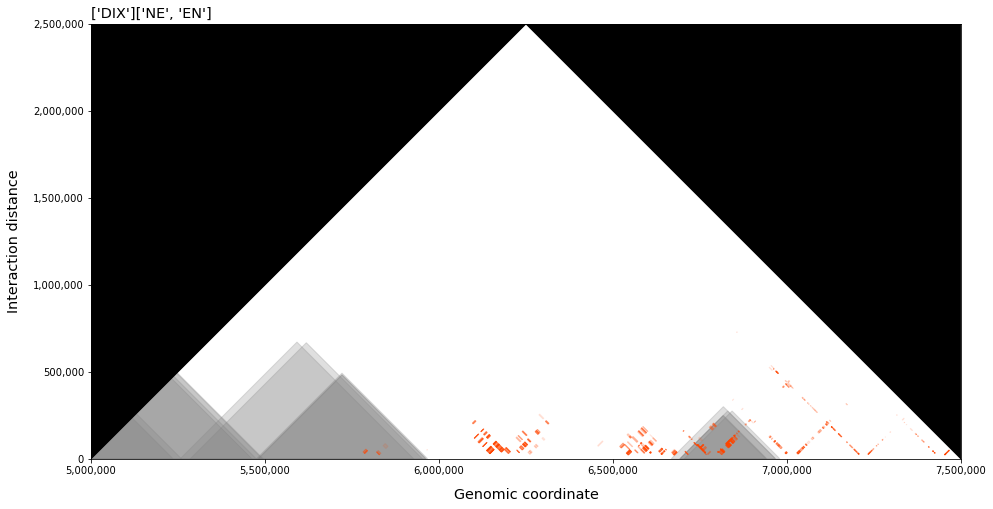

[INFO] Extracted 3169 interactions in range chr1:5000000-7500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  26.  34.  50.  73. 339.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 5000000 max: 7500000
[INFO] Got 1069 interactions
[INFO] begin: 5000000
[INFO] end: 7500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 5000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 7500000.0


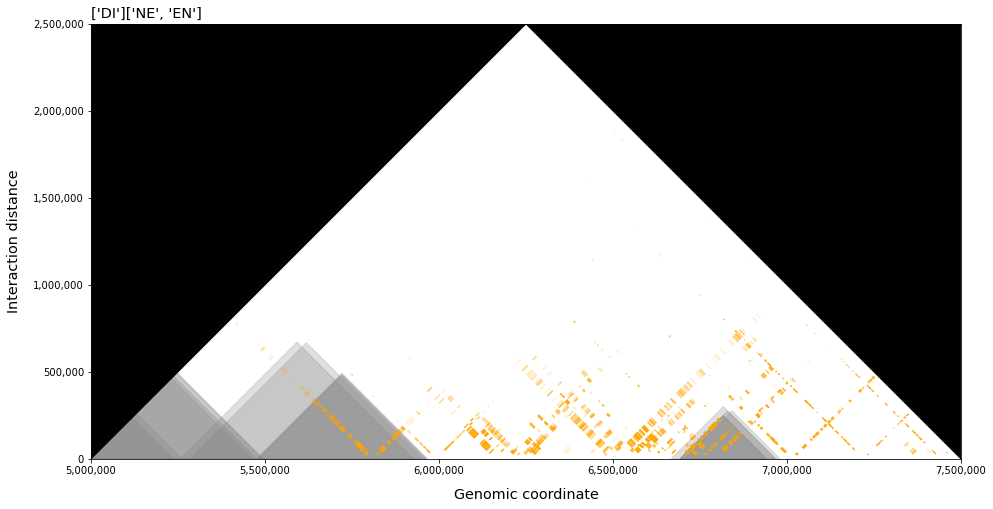

[INFO] Extracted 3169 interactions in range chr1:5000000-7500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  18.  23.  28.  34.  44.  67. 349.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 5000000 max: 7500000
[INFO] Got 1158 interactions
[INFO] begin: 5000000
[INFO] end: 7500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 5000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 7500000.0


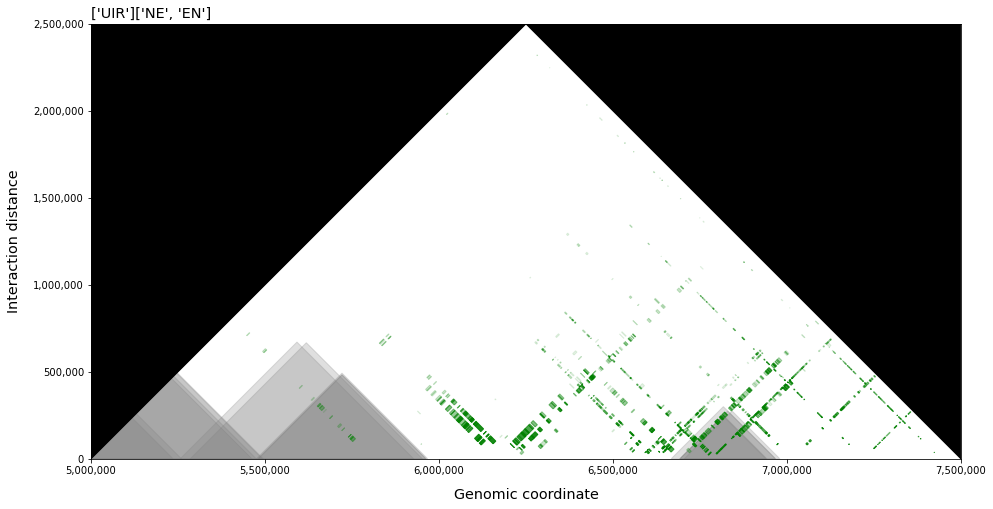

[INFO] Extracted 3169 interactions in range chr1:5000000-7500000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 11. 12. 14. 17. 34.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 5000000 max: 7500000
[INFO] Got 576 interactions
[INFO] begin: 5000000
[INFO] end: 7500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 5000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 7500000.0


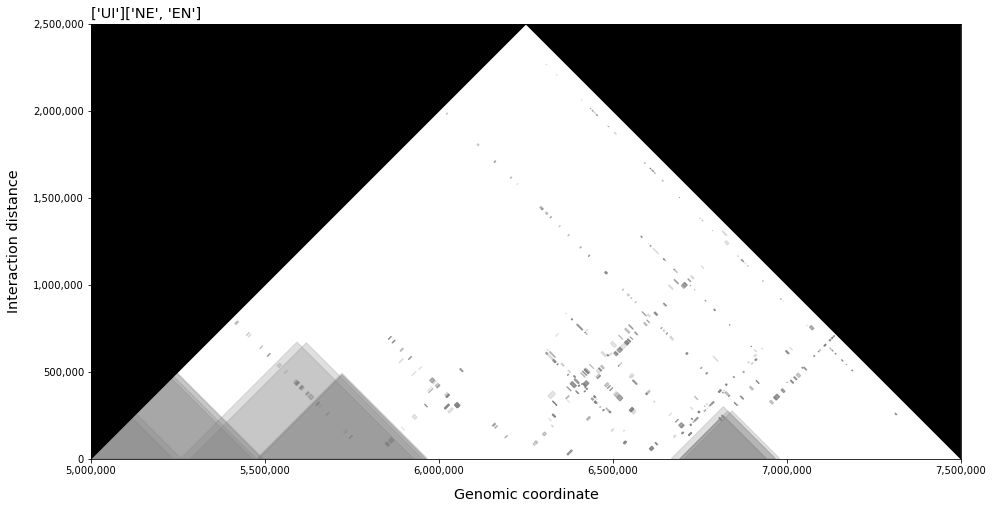

[INFO] Extracted 5651 interactions in range chr1:7500000-10000000
[INFO] Read pair count quantiles:
	[INFO] [ 45.   57.   72.   83.   95.  115.  146.  179.8 249.8 568. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 7500000 max: 10000000
[INFO] Got 542 interactions
[INFO] begin: 7500000
[INFO] end: 10000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 7500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 10000000.0


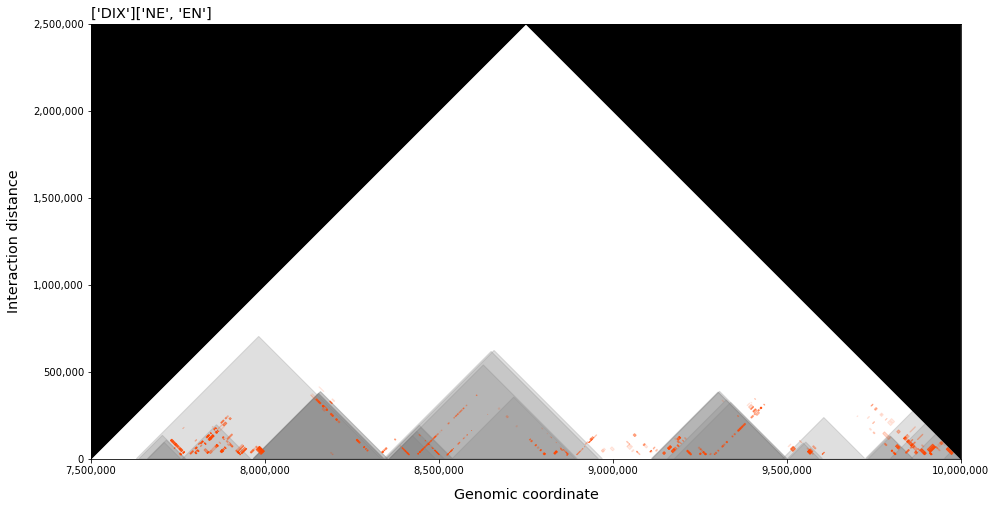

[INFO] Extracted 5651 interactions in range chr1:7500000-10000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  21.  25.  31.  40.  64. 348.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 7500000 max: 10000000
[INFO] Got 2296 interactions
[INFO] begin: 7500000
[INFO] end: 10000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 7500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 10000000.0


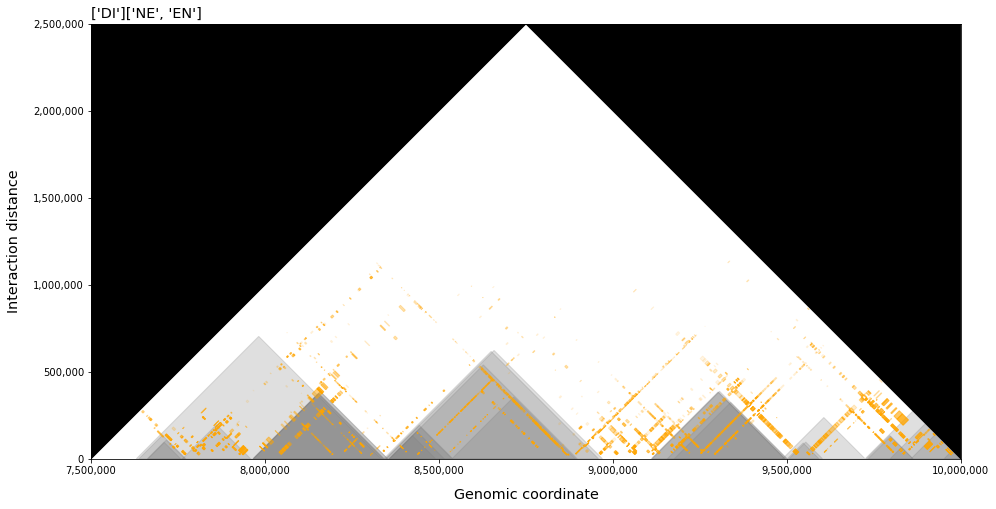

[INFO] Extracted 5651 interactions in range chr1:7500000-10000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.   12.   15.   18.   23.   28.   35.   48.   85.6 389. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 7500000 max: 10000000
[INFO] Got 1825 interactions
[INFO] begin: 7500000
[INFO] end: 10000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 7500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 10000000.0


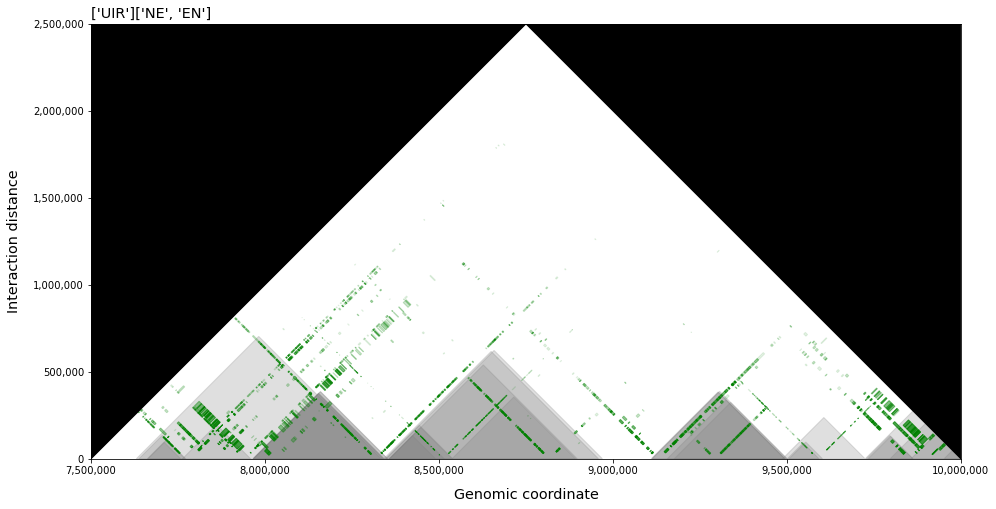

[INFO] Extracted 5651 interactions in range chr1:7500000-10000000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 12. 13. 14. 17. 31.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 7500000 max: 10000000
[INFO] Got 988 interactions
[INFO] begin: 7500000
[INFO] end: 10000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 7500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 10000000.0


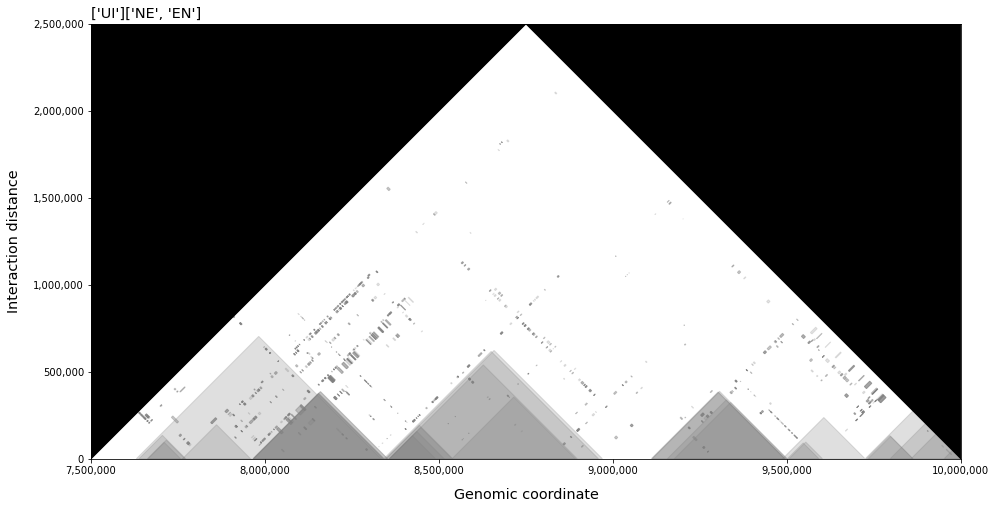

[INFO] Extracted 7451 interactions in range chr1:10000000-12500000
[INFO] Read pair count quantiles:
	[INFO] [ 43.   54.   64.   74.6  88.  105.  126.  158.  215.1 910. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 10000000 max: 12500000
[INFO] Got 780 interactions
[INFO] begin: 10000000
[INFO] end: 12500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 12500000.0


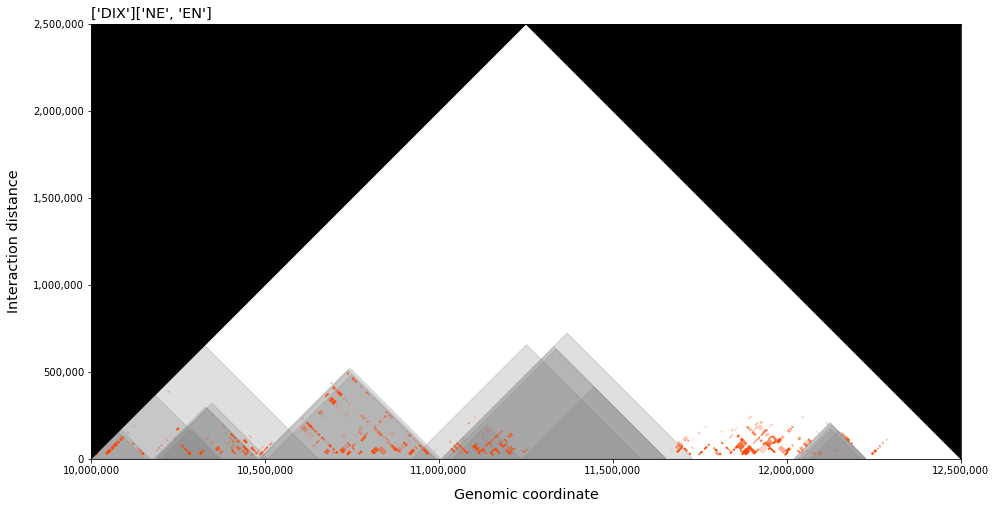

[INFO] Extracted 7451 interactions in range chr1:10000000-12500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  23.  29.  37.  55. 408.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 10000000 max: 12500000
[INFO] Got 3307 interactions
[INFO] begin: 10000000
[INFO] end: 12500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 12500000.0


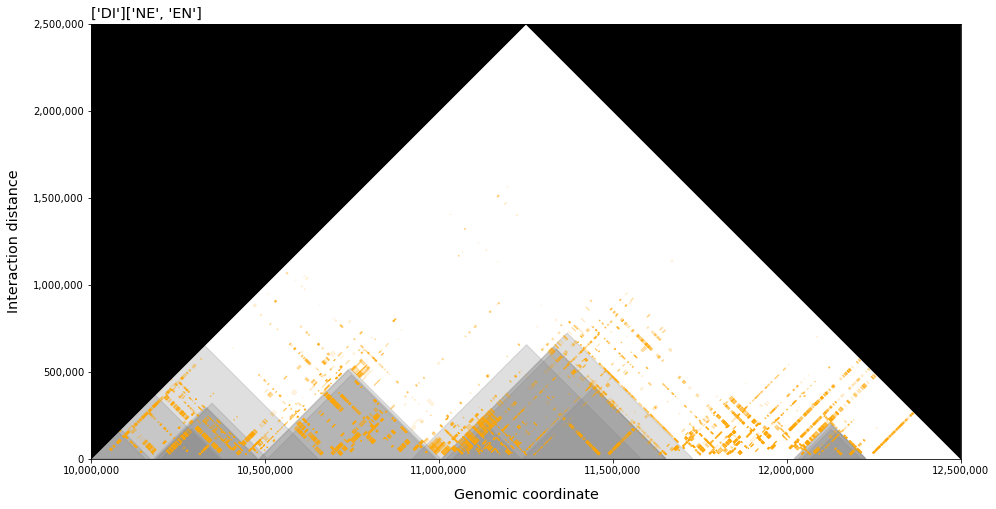

[INFO] Extracted 7451 interactions in range chr1:10000000-12500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  20.  24.  30.  39.  57. 348.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 10000000 max: 12500000
[INFO] Got 2169 interactions
[INFO] begin: 10000000
[INFO] end: 12500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 12500000.0


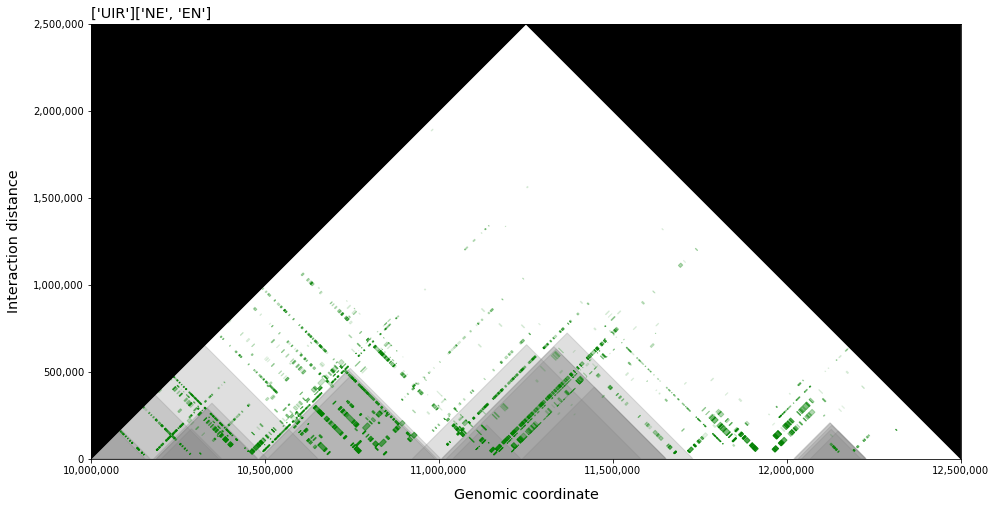

[INFO] Extracted 7451 interactions in range chr1:10000000-12500000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 12. 13. 15. 17. 34.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 10000000 max: 12500000
[INFO] Got 1195 interactions
[INFO] begin: 10000000
[INFO] end: 12500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 10000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 12500000.0


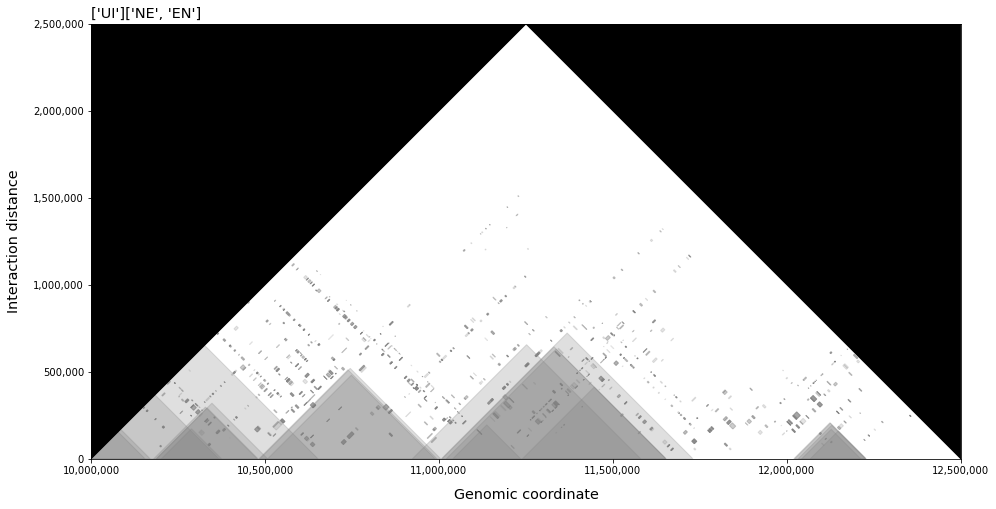

[INFO] Extracted 2211 interactions in range chr1:12500000-15000000
[INFO] Read pair count quantiles:
	[INFO] [ 40.   50.   54.4  61.2  68.   85.  101.8 136.6 178.6 284. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 12500000 max: 15000000
[INFO] Got 109 interactions
[INFO] begin: 12500000
[INFO] end: 15000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15000000.0


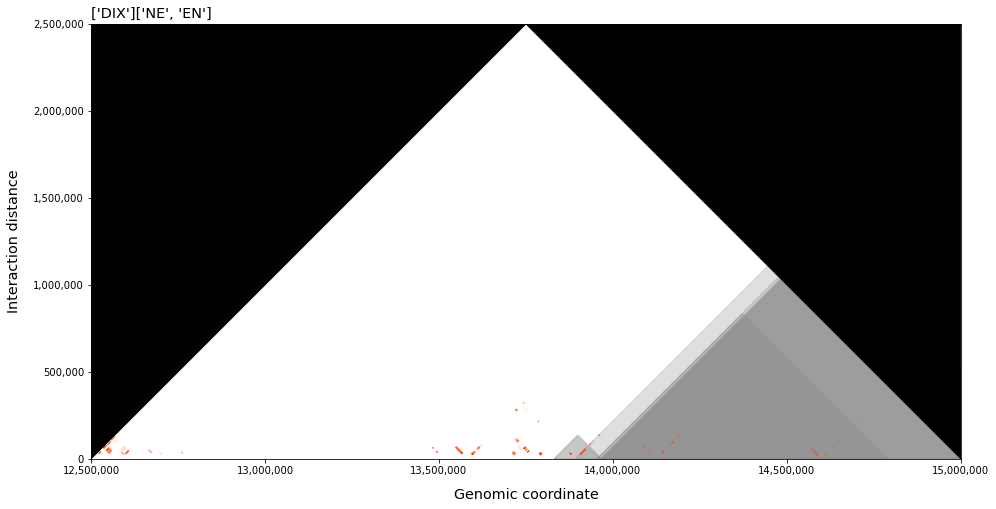

[INFO] Extracted 2211 interactions in range chr1:12500000-15000000
[INFO] Read pair count quantiles:
	[INFO] [ 11.  13.  16.  19.  22.  26.  31.  38.  57. 425.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 12500000 max: 15000000
[INFO] Got 639 interactions
[INFO] begin: 12500000
[INFO] end: 15000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15000000.0


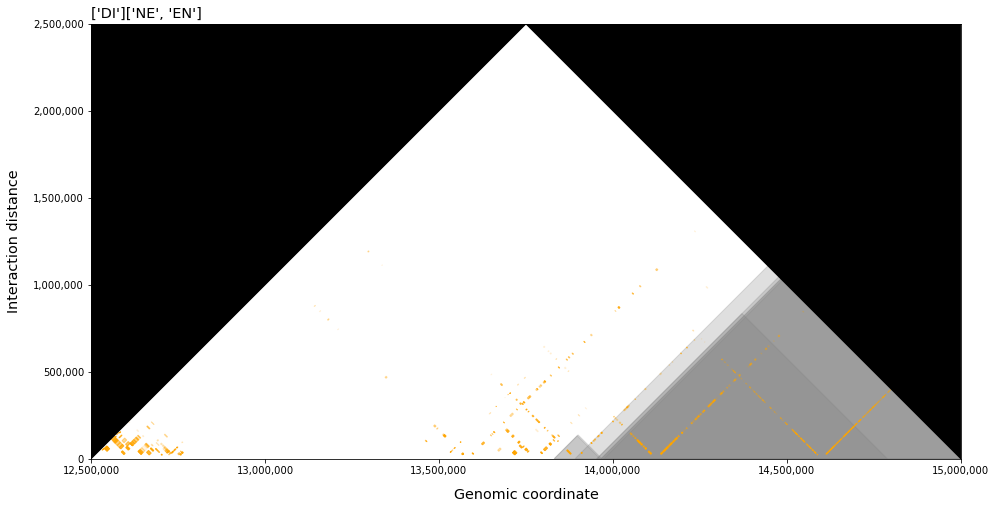

[INFO] Extracted 2211 interactions in range chr1:12500000-15000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  21.  25.  30.  39.  53. 333.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 12500000 max: 15000000
[INFO] Got 973 interactions
[INFO] begin: 12500000
[INFO] end: 15000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15000000.0


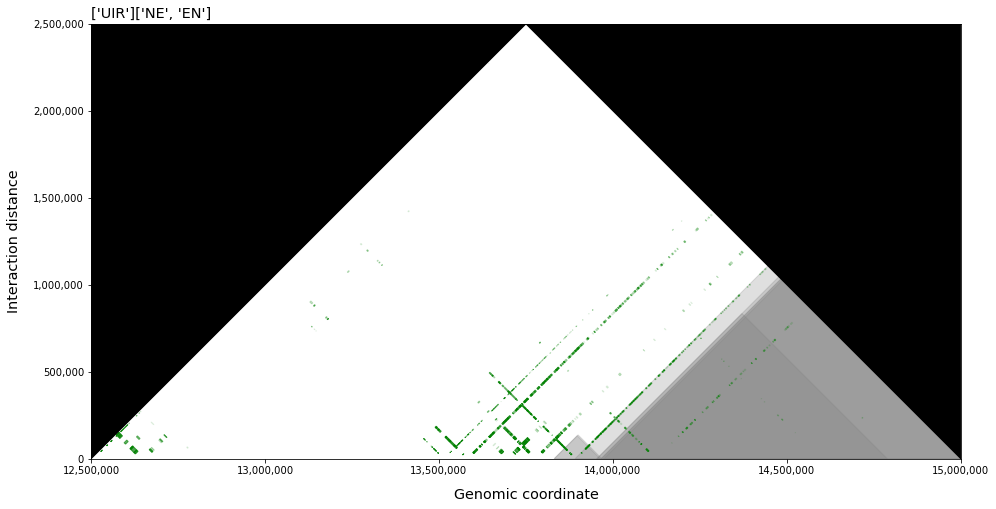

[INFO] Extracted 2211 interactions in range chr1:12500000-15000000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  10.  10.  11.  11.  12.  13.3 15.  18.1 29. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 12500000 max: 15000000
[INFO] Got 490 interactions
[INFO] begin: 12500000
[INFO] end: 15000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 12500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 15000000.0


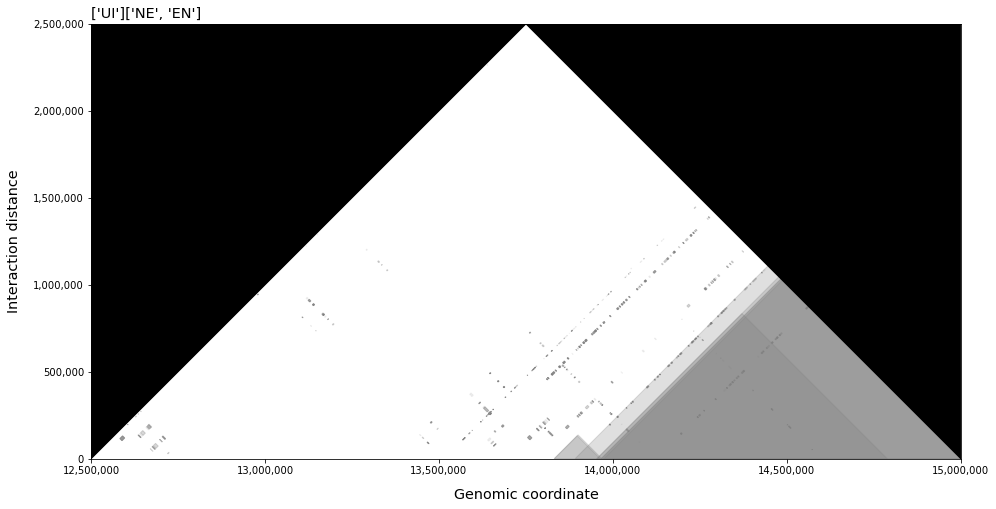

[INFO] Extracted 4352 interactions in range chr1:15000000-17500000
[INFO] Read pair count quantiles:
	[INFO] [ 46.   62.   74.   88.  105.  134.  156.  196.4 246.6 575. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 15000000 max: 17500000
[INFO] Got 655 interactions
[INFO] begin: 15000000
[INFO] end: 17500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 15000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 17500000.0


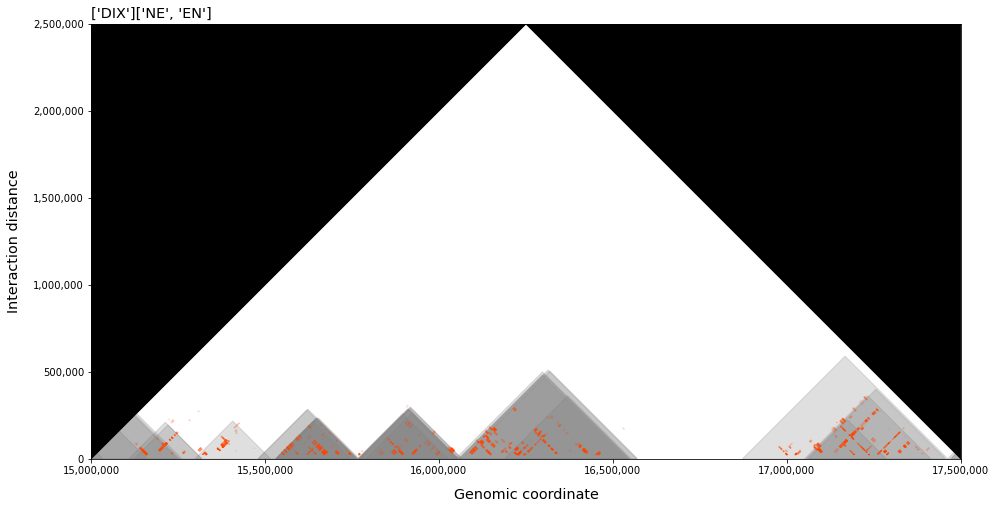

[INFO] Extracted 4352 interactions in range chr1:15000000-17500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  17.  21.  25.  32.  45.  70. 417.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 15000000 max: 17500000
[INFO] Got 2126 interactions
[INFO] begin: 15000000
[INFO] end: 17500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 15000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 17500000.0


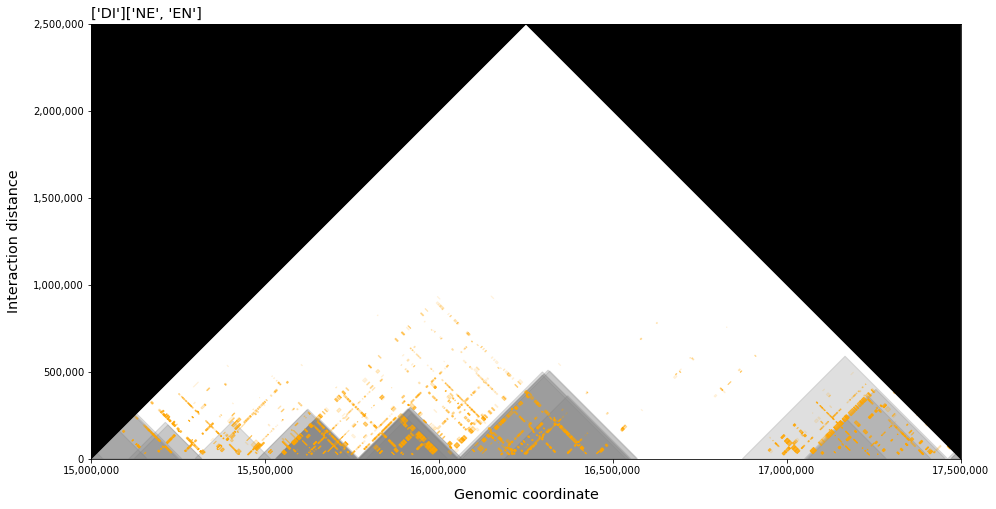

[INFO] Extracted 4352 interactions in range chr1:15000000-17500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  21.  25.  32.  42.  65. 335.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 15000000 max: 17500000
[INFO] Got 1000 interactions
[INFO] begin: 15000000
[INFO] end: 17500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 15000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 17500000.0


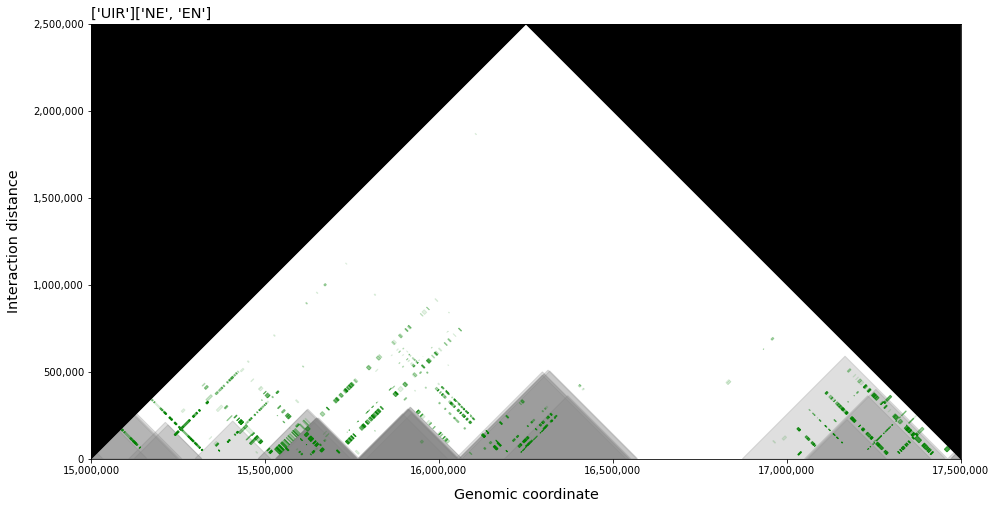

[INFO] Extracted 4352 interactions in range chr1:15000000-17500000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 11. 11. 12. 13. 15. 18. 29.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 15000000 max: 17500000
[INFO] Got 571 interactions
[INFO] begin: 15000000
[INFO] end: 17500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 15000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 17500000.0


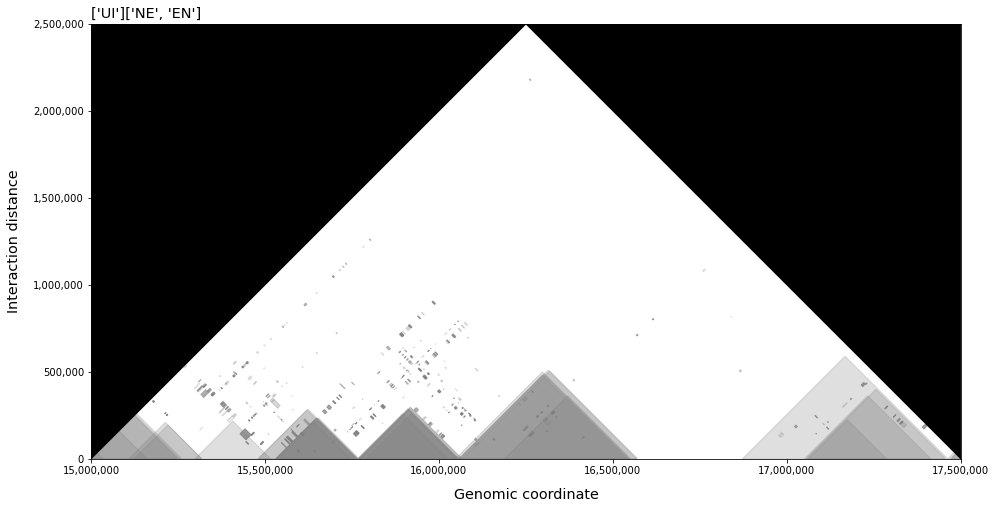

[INFO] Extracted 5046 interactions in range chr1:17500000-20000000
[INFO] Read pair count quantiles:
	[INFO] [ 50.  62.  76.  91. 105. 132. 157. 187. 278. 921.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 17500000 max: 20000000
[INFO] Got 541 interactions
[INFO] begin: 17500000
[INFO] end: 20000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 17500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 20000000.0


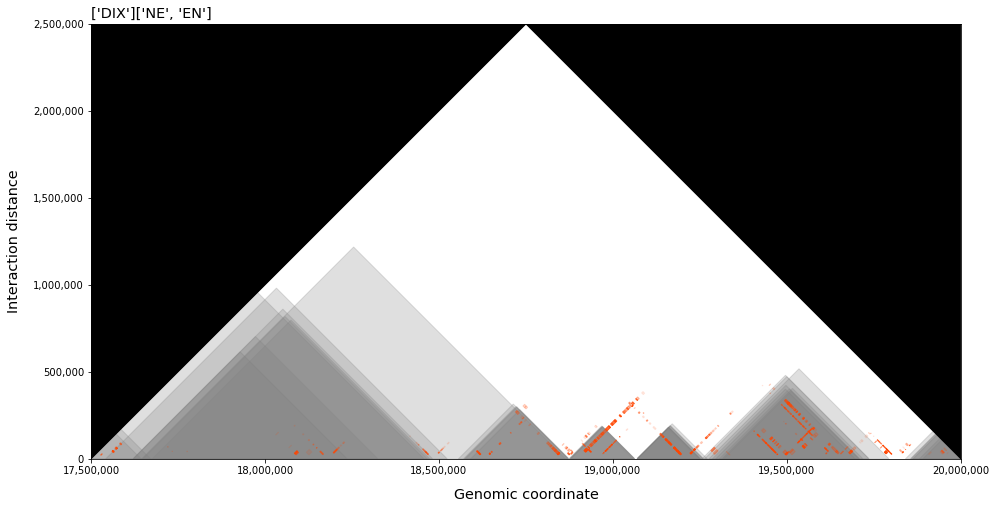

[INFO] Extracted 5046 interactions in range chr1:17500000-20000000
[INFO] Read pair count quantiles:
	[INFO] [ 11.   13.   16.   19.   23.   28.   36.   49.   77.6 531. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 17500000 max: 20000000
[INFO] Got 1525 interactions
[INFO] begin: 17500000
[INFO] end: 20000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 17500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 20000000.0


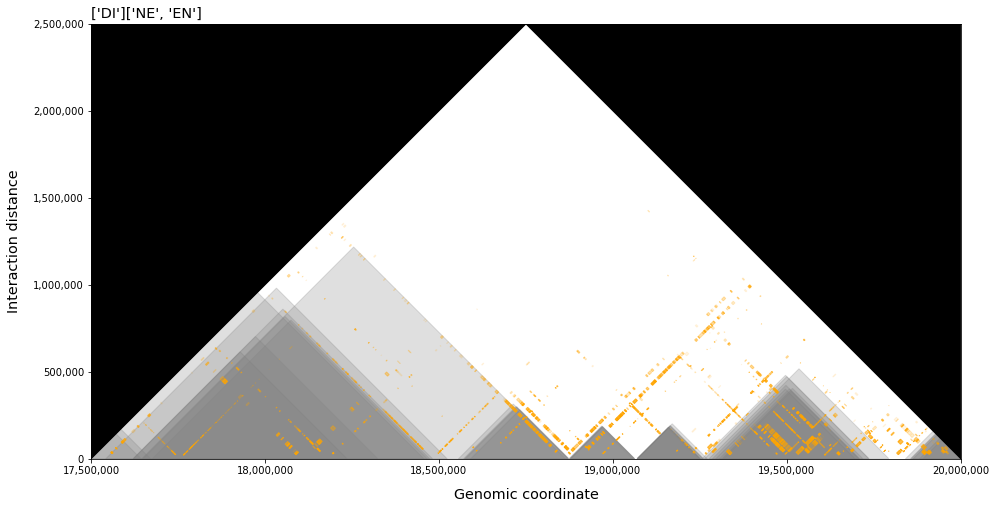

[INFO] Extracted 5046 interactions in range chr1:17500000-20000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  17.  20.  22.  27.  35.  51. 307.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 17500000 max: 20000000
[INFO] Got 1931 interactions
[INFO] begin: 17500000
[INFO] end: 20000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 17500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 20000000.0


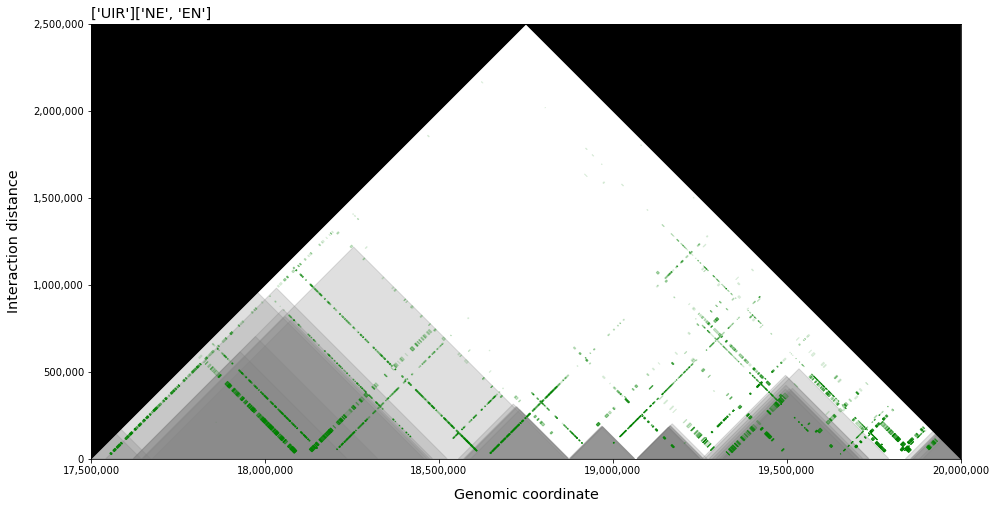

[INFO] Extracted 5046 interactions in range chr1:17500000-20000000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 11. 11. 13. 14. 16. 19. 31.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 17500000 max: 20000000
[INFO] Got 1049 interactions
[INFO] begin: 17500000
[INFO] end: 20000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 17500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 20000000.0


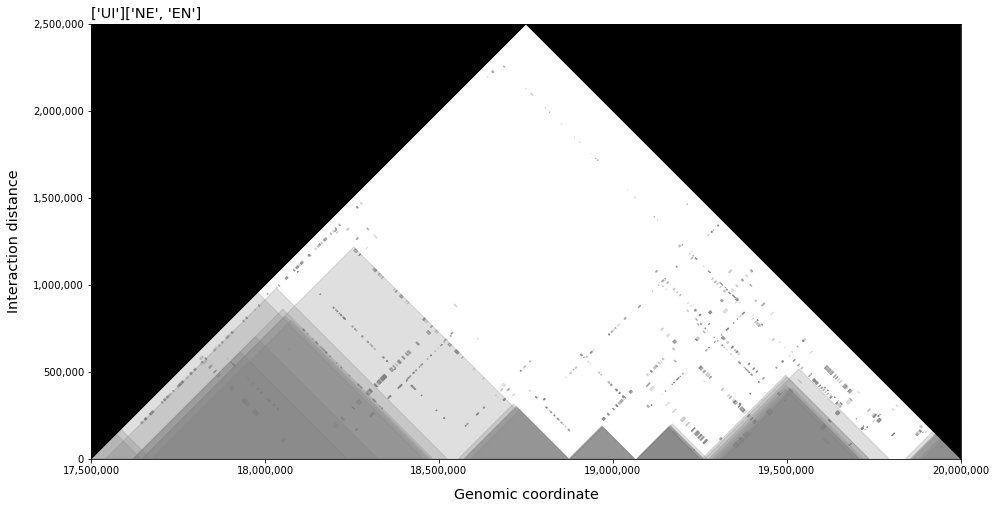

[INFO] Extracted 4982 interactions in range chr1:20000000-22500000
[INFO] Read pair count quantiles:
	[INFO] [ 50.1  65.   79.   95.  114.  134.  173.  216.8 295.  627. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 20000000 max: 22500000
[INFO] Got 552 interactions
[INFO] begin: 20000000
[INFO] end: 22500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 20000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 22500000.0


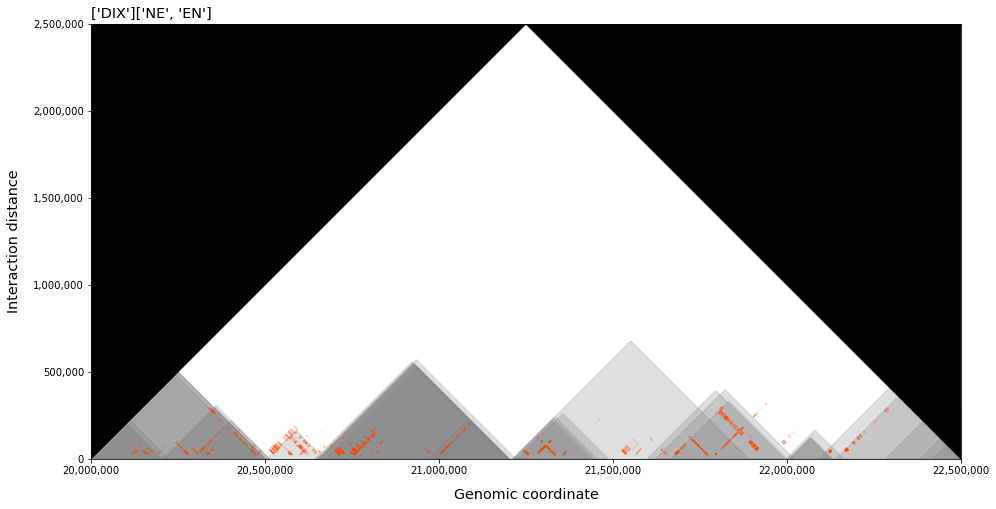

[INFO] Extracted 4982 interactions in range chr1:20000000-22500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.   13.   16.   19.   23.5  29.   36.   49.4  78.  357. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 20000000 max: 22500000
[INFO] Got 1684 interactions
[INFO] begin: 20000000
[INFO] end: 22500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 20000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 22500000.0


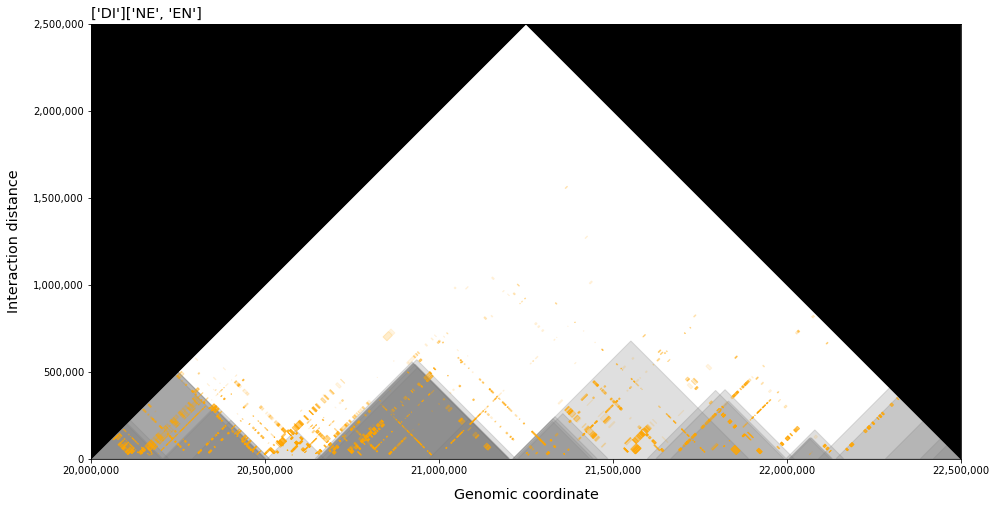

[INFO] Extracted 4982 interactions in range chr1:20000000-22500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.   13.   15.   18.   21.   25.   31.   39.   57.1 339. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 20000000 max: 22500000
[INFO] Got 1820 interactions
[INFO] begin: 20000000
[INFO] end: 22500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 20000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 22500000.0


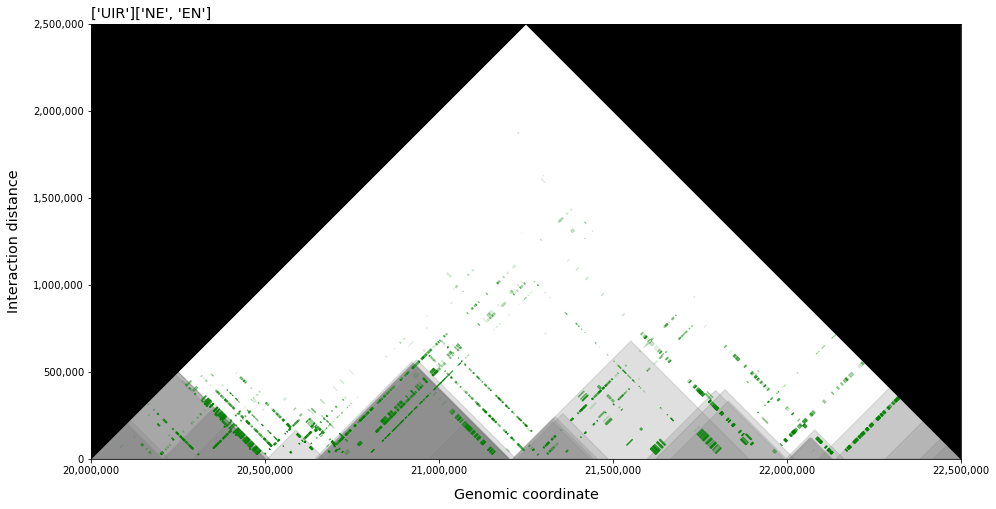

[INFO] Extracted 4982 interactions in range chr1:20000000-22500000
[INFO] Read pair count quantiles:
	[INFO] [ 9. 10. 10. 11. 11. 12. 13. 15. 18. 30.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 20000000 max: 22500000
[INFO] Got 926 interactions
[INFO] begin: 20000000
[INFO] end: 22500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 20000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 22500000.0


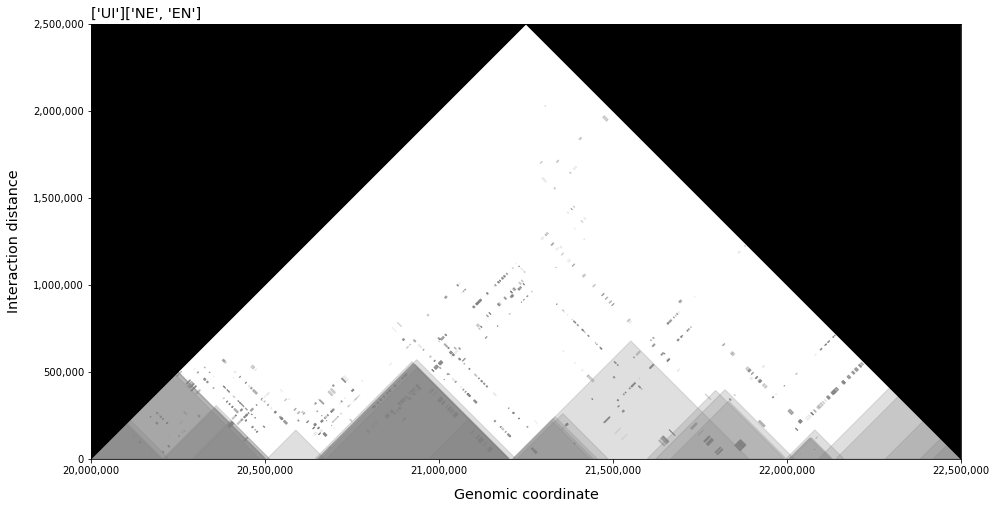

[INFO] Extracted 8073 interactions in range chr1:22500000-25000000
[INFO] Read pair count quantiles:
	[INFO] [ 43.   53.4  66.   79.8  95.  112.  138.  182.6 255.2 778. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 22500000 max: 25000000
[INFO] Got 858 interactions
[INFO] begin: 22500000
[INFO] end: 25000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 22500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 25000000.0


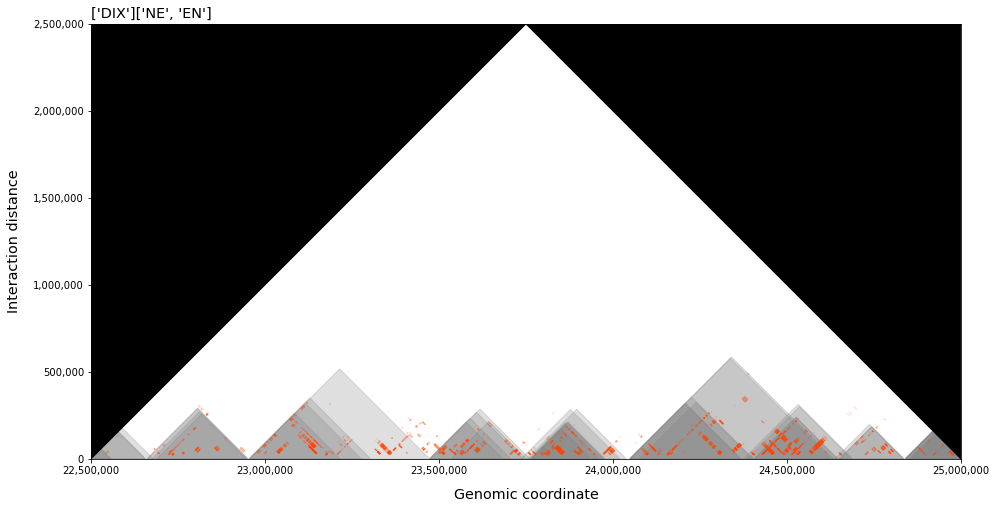

[INFO] Extracted 8073 interactions in range chr1:22500000-25000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  18.  21.  26.  32.  43.  68. 424.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 22500000 max: 25000000
[INFO] Got 3159 interactions
[INFO] begin: 22500000
[INFO] end: 25000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 22500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 25000000.0


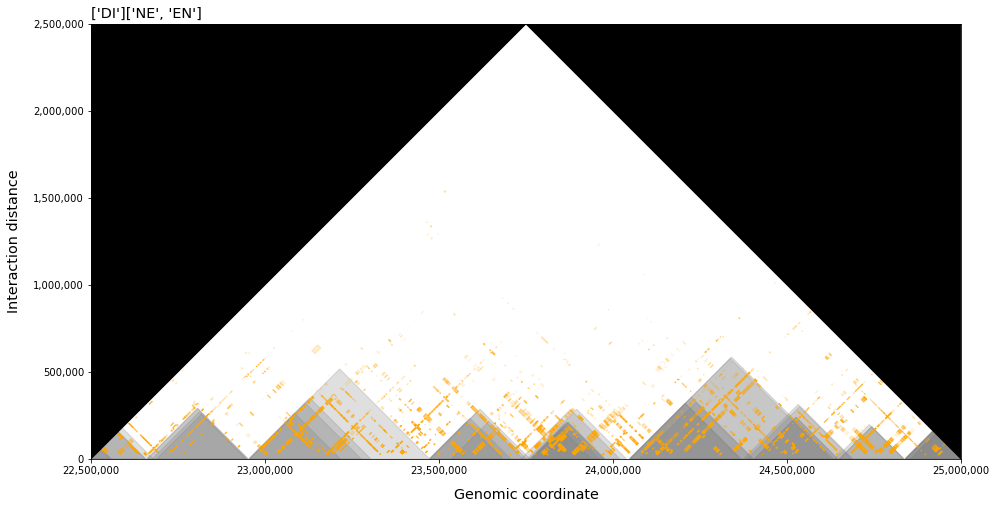

[INFO] Extracted 8073 interactions in range chr1:22500000-25000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.   12.   15.   18.   22.   27.   33.   43.   64.3 500. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 22500000 max: 25000000
[INFO] Got 2668 interactions
[INFO] begin: 22500000
[INFO] end: 25000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 22500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 25000000.0


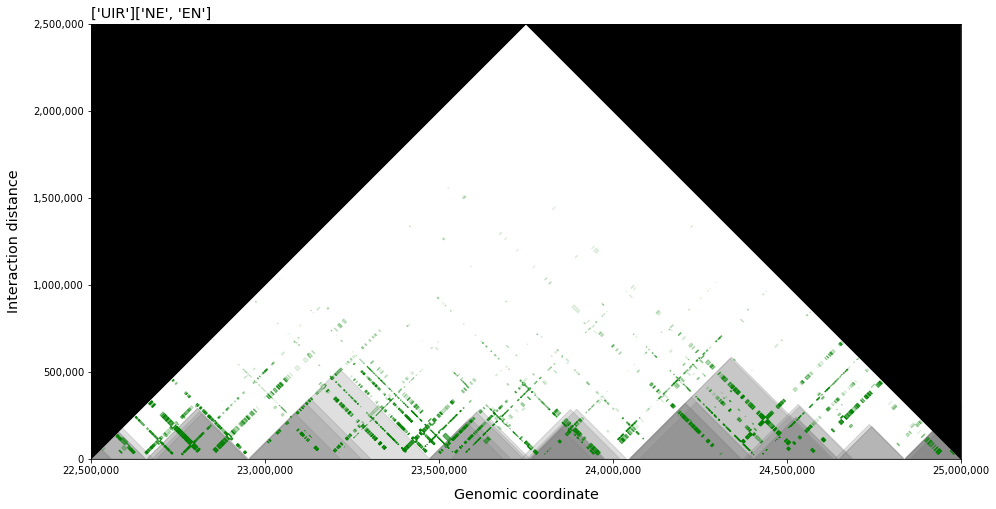

[INFO] Extracted 8073 interactions in range chr1:22500000-25000000
[INFO] Read pair count quantiles:
	[INFO] [ 9. 10. 10. 11. 11. 12. 13. 15. 19. 34.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 22500000 max: 25000000
[INFO] Got 1388 interactions
[INFO] begin: 22500000
[INFO] end: 25000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 22500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 25000000.0


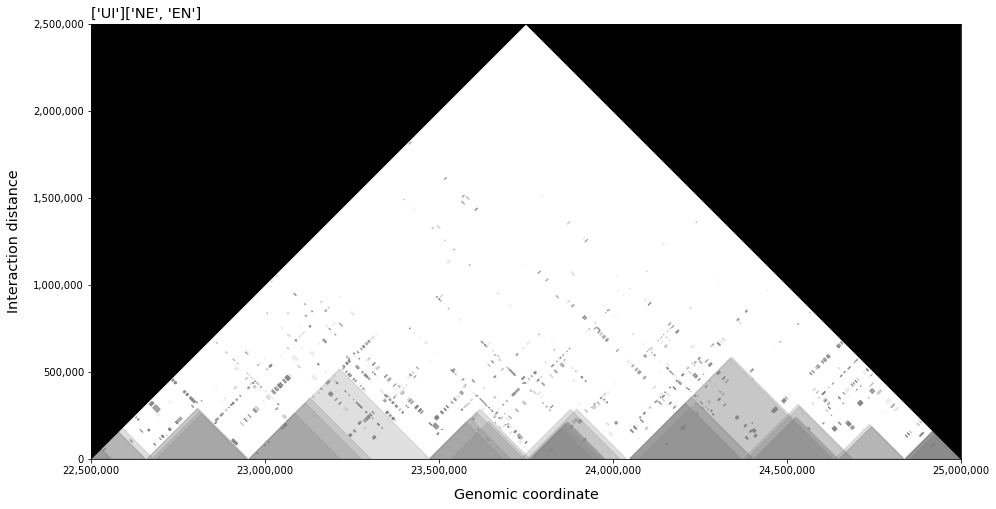

[INFO] Extracted 9043 interactions in range chr1:25000000-27500000
[INFO] Read pair count quantiles:
	[INFO] [  45.   57.   70.   84.  103.  127.  161.  205.  295. 1730.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 25000000 max: 27500000
[INFO] Got 1289 interactions
[INFO] begin: 25000000
[INFO] end: 27500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 25000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 27500000.0


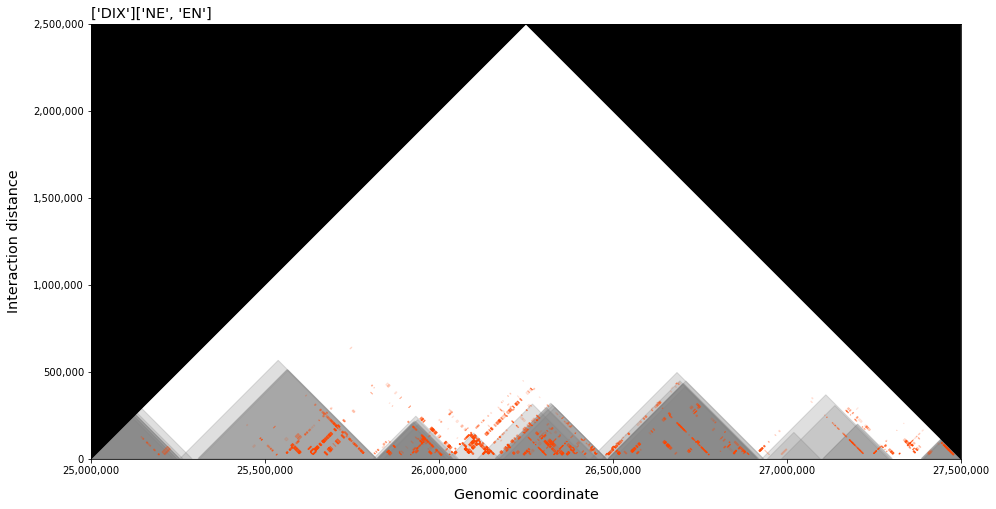

[INFO] Extracted 9043 interactions in range chr1:25000000-27500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  16.  19.  24.  30.  39.  53.  82. 511.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 25000000 max: 27500000
[INFO] Got 3256 interactions
[INFO] begin: 25000000
[INFO] end: 27500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 25000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 27500000.0


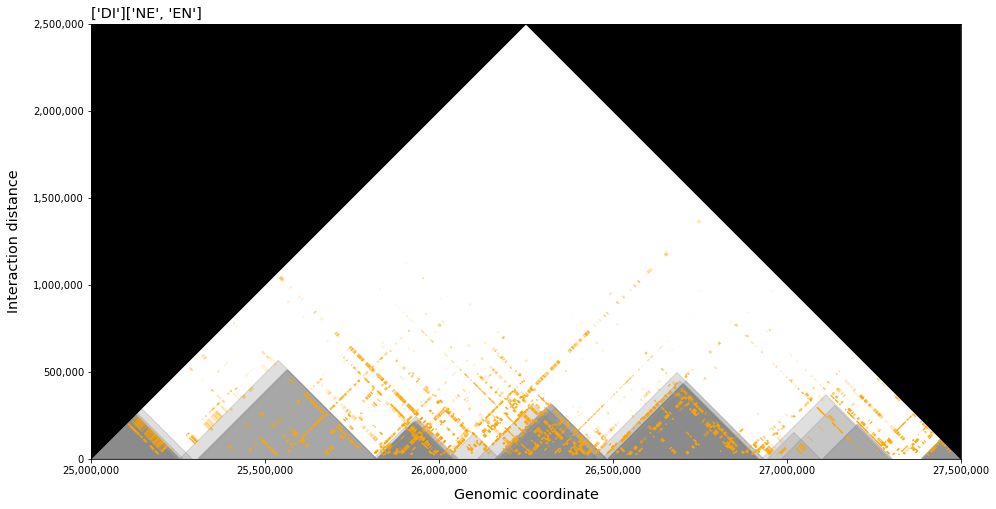

[INFO] Extracted 9043 interactions in range chr1:25000000-27500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  17.  21.  26.  34.  45.  75. 472.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 25000000 max: 27500000
[INFO] Got 2875 interactions
[INFO] begin: 25000000
[INFO] end: 27500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 25000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 27500000.0


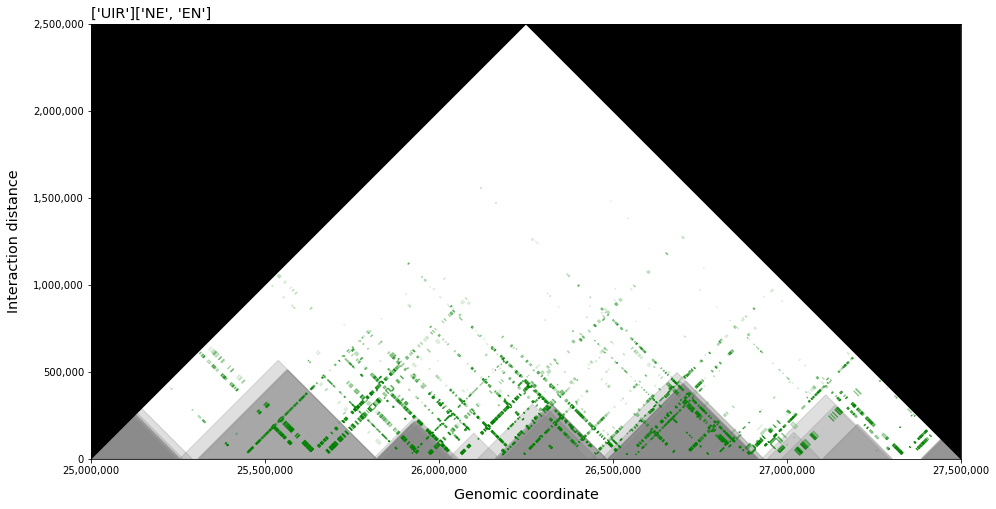

[INFO] Extracted 9043 interactions in range chr1:25000000-27500000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 12. 13. 14. 17. 29.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 25000000 max: 27500000
[INFO] Got 1623 interactions
[INFO] begin: 25000000
[INFO] end: 27500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 25000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 27500000.0


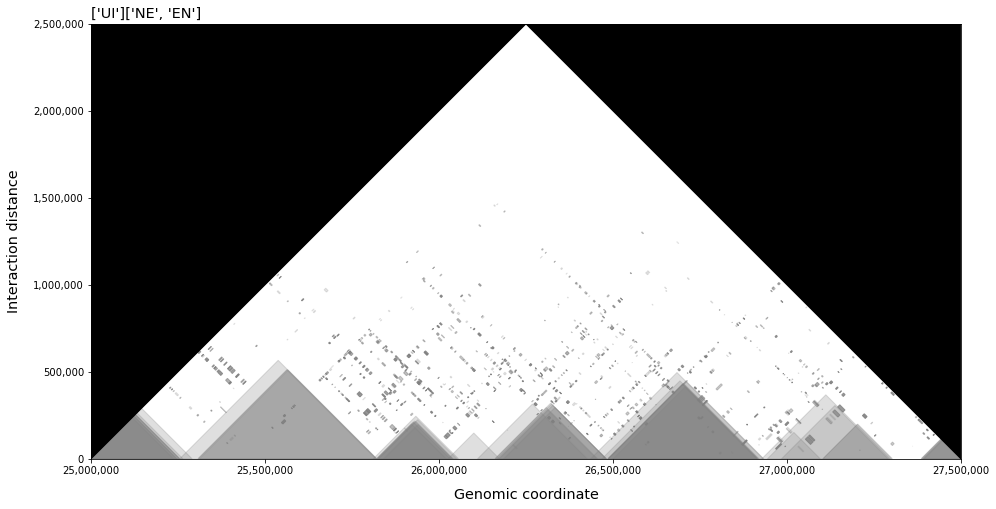

[INFO] Extracted 6178 interactions in range chr1:27500000-30000000
[INFO] Read pair count quantiles:
	[INFO] [ 43.   52.   62.3  75.   89.  108.  132.7 178.8 239.9 796. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 27500000 max: 30000000
[INFO] Got 732 interactions
[INFO] begin: 27500000
[INFO] end: 30000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 27500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 30000000.0


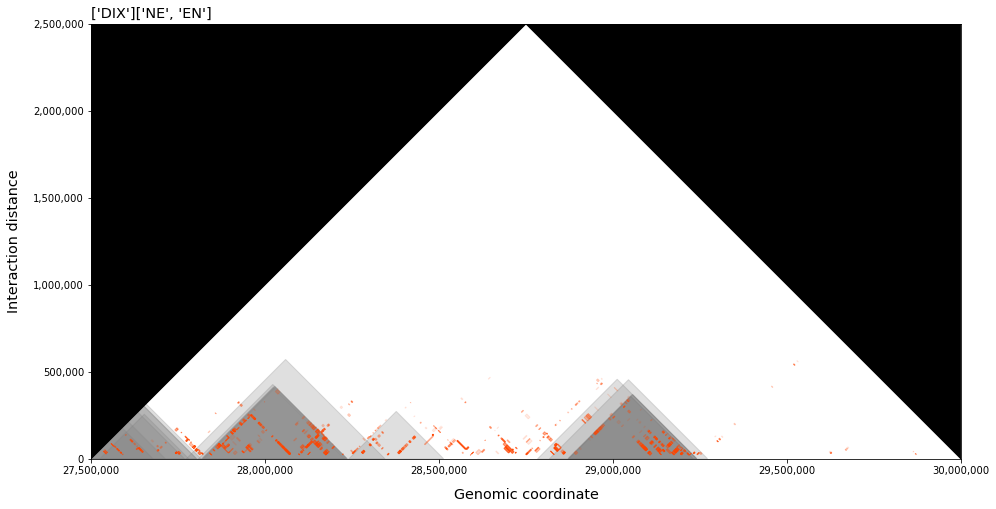

[INFO] Extracted 6178 interactions in range chr1:27500000-30000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  21.  25.  31.  42.  64. 555.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 27500000 max: 30000000
[INFO] Got 2826 interactions
[INFO] begin: 27500000
[INFO] end: 30000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 27500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 30000000.0


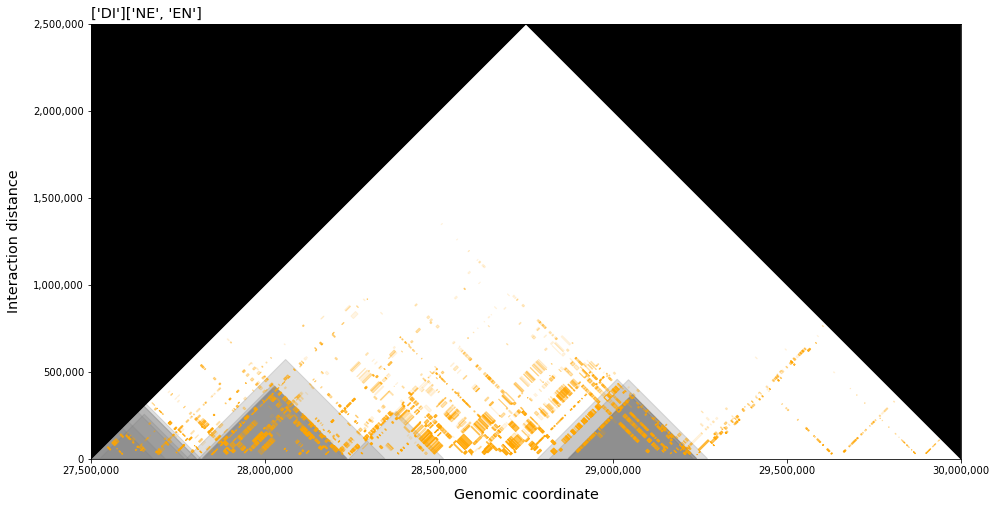

[INFO] Extracted 6178 interactions in range chr1:27500000-30000000
[INFO] Read pair count quantiles:
	[INFO] [ 11.  13.  16.  20.  24.  28.  34.  45.  64. 506.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 27500000 max: 30000000
[INFO] Got 1815 interactions
[INFO] begin: 27500000
[INFO] end: 30000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 27500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 30000000.0


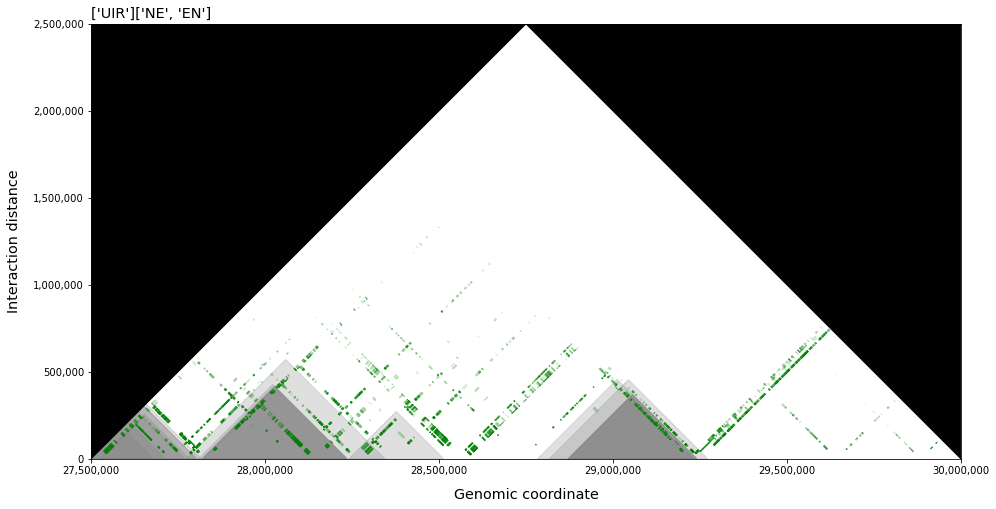

[INFO] Extracted 6178 interactions in range chr1:27500000-30000000
[INFO] Read pair count quantiles:
	[INFO] [ 9. 10. 10. 11. 11. 12. 14. 16. 19. 34.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 27500000 max: 30000000
[INFO] Got 805 interactions
[INFO] begin: 27500000
[INFO] end: 30000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 27500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 30000000.0


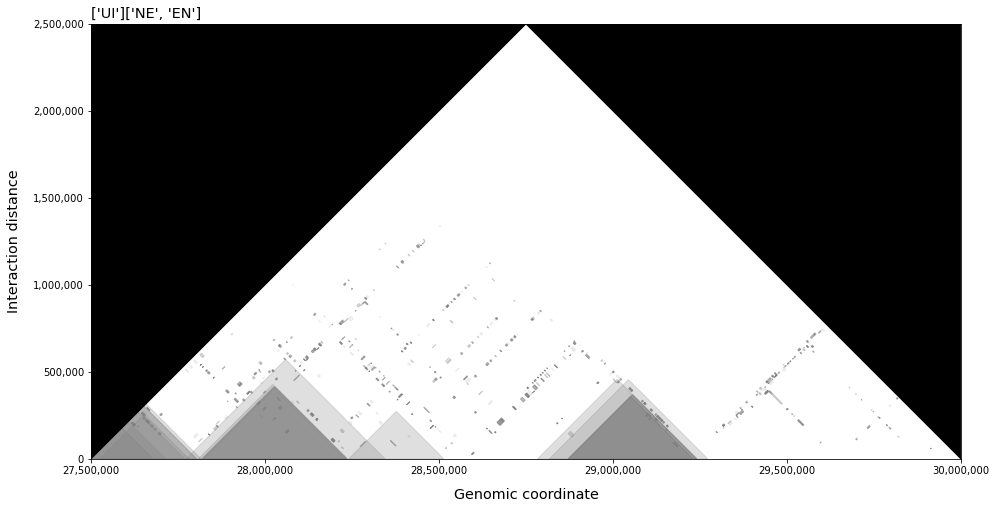

[INFO] Extracted 5596 interactions in range chr1:30000000-32500000
[INFO] Read pair count quantiles:
	[INFO] [ 43.  56.  67.  81. 100. 122. 156. 197. 267. 955.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 30000000 max: 32500000
[INFO] Got 751 interactions
[INFO] begin: 30000000
[INFO] end: 32500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 30000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 32500000.0


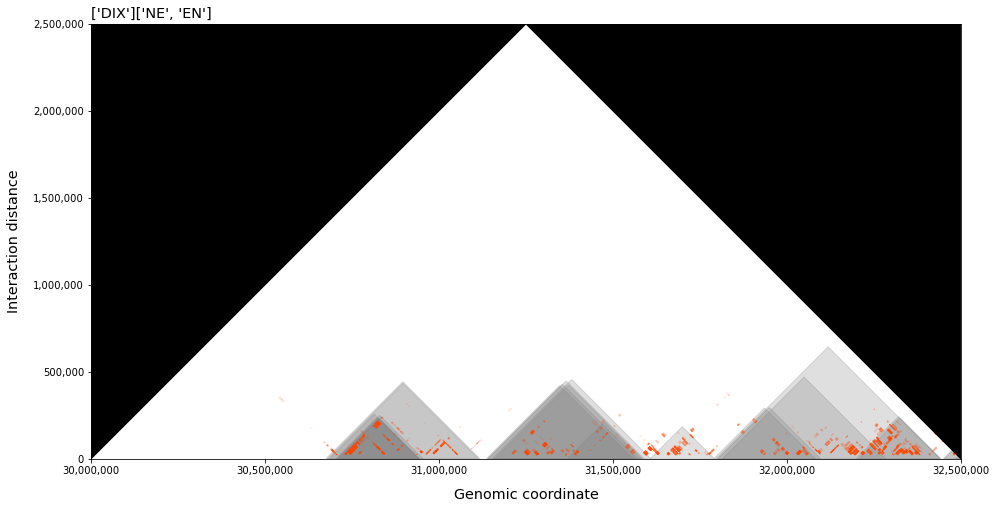

[INFO] Extracted 5596 interactions in range chr1:30000000-32500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.   12.   15.   18.   21.   26.   32.   43.   65.6 712. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 30000000 max: 32500000
[INFO] Got 2515 interactions
[INFO] begin: 30000000
[INFO] end: 32500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 30000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 32500000.0


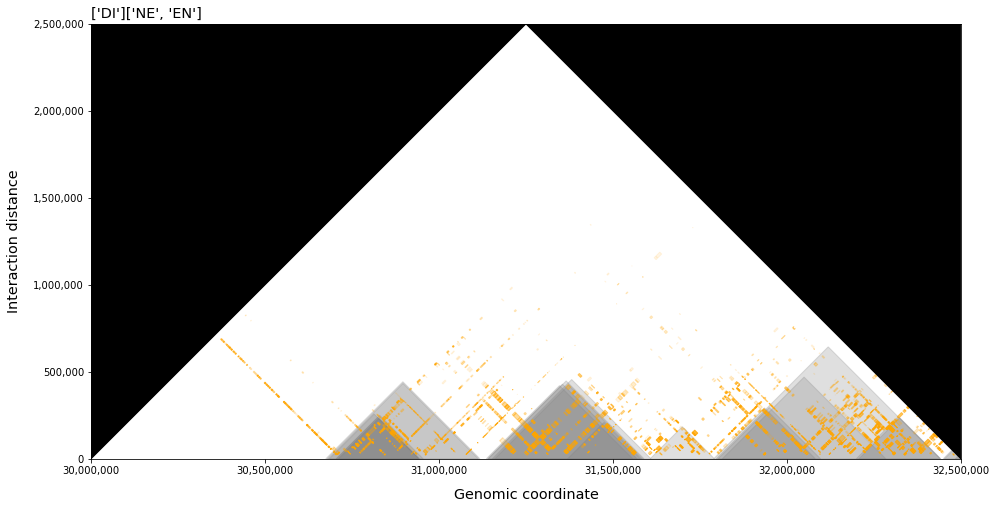

[INFO] Extracted 5596 interactions in range chr1:30000000-32500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  22.  28.  35.  47.  70. 423.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 30000000 max: 32500000
[INFO] Got 1517 interactions
[INFO] begin: 30000000
[INFO] end: 32500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 30000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 32500000.0


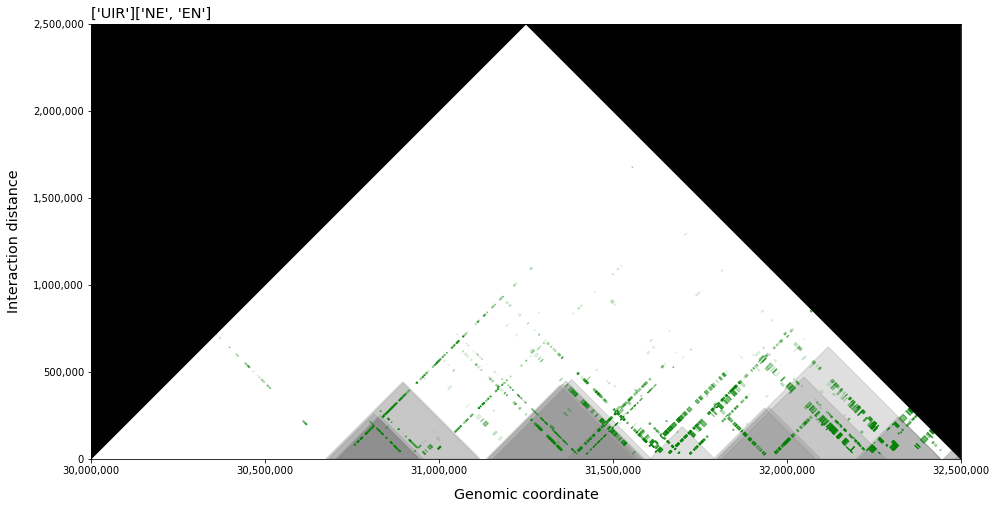

[INFO] Extracted 5596 interactions in range chr1:30000000-32500000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 12. 13. 15. 18. 31.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 30000000 max: 32500000
[INFO] Got 813 interactions
[INFO] begin: 30000000
[INFO] end: 32500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 30000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 32500000.0


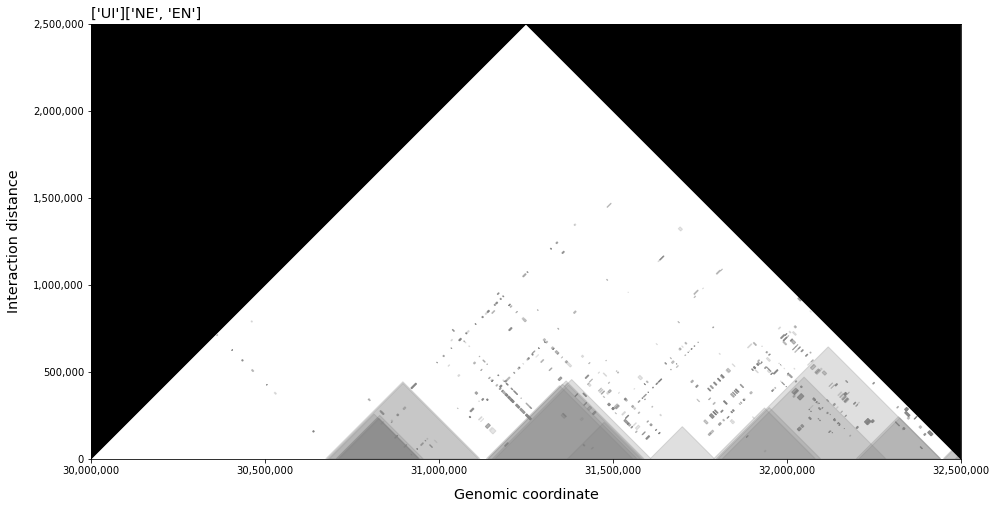

[INFO] Extracted 5245 interactions in range chr1:32500000-35000000
[INFO] Read pair count quantiles:
	[INFO] [ 46.   58.   70.   83.   98.5 116.4 138.  169.2 225.4 534. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 32500000 max: 35000000
[INFO] Got 560 interactions
[INFO] begin: 32500000
[INFO] end: 35000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 32500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 35000000.0


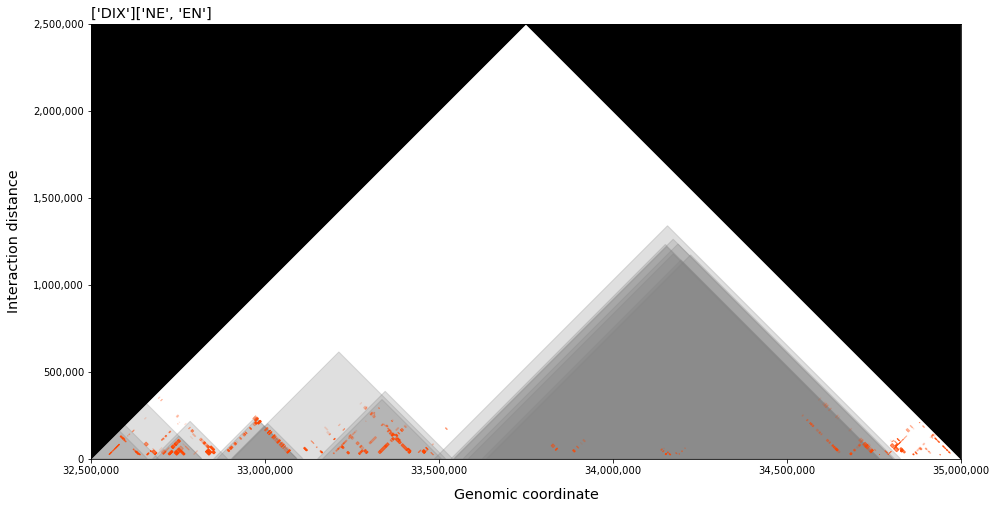

[INFO] Extracted 5245 interactions in range chr1:32500000-35000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.   13.   15.   19.   22.   27.   34.   47.   71.6 475. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 32500000 max: 35000000
[INFO] Got 1645 interactions
[INFO] begin: 32500000
[INFO] end: 35000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 32500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 35000000.0


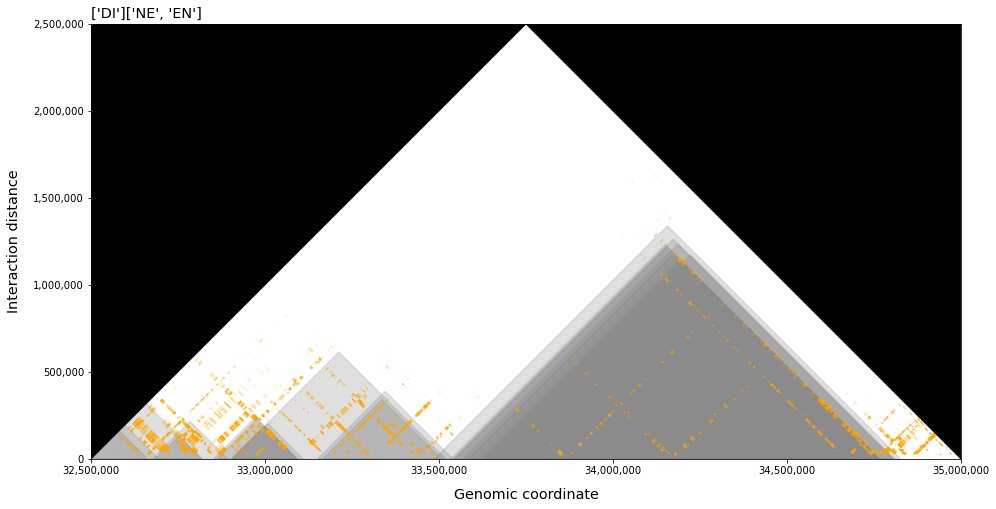

[INFO] Extracted 5245 interactions in range chr1:32500000-35000000
[INFO] Read pair count quantiles:
	[INFO] [ 11.   13.   16.   19.   22.   26.   31.   42.   63.8 455. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 32500000 max: 35000000
[INFO] Got 2103 interactions
[INFO] begin: 32500000
[INFO] end: 35000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 32500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 35000000.0


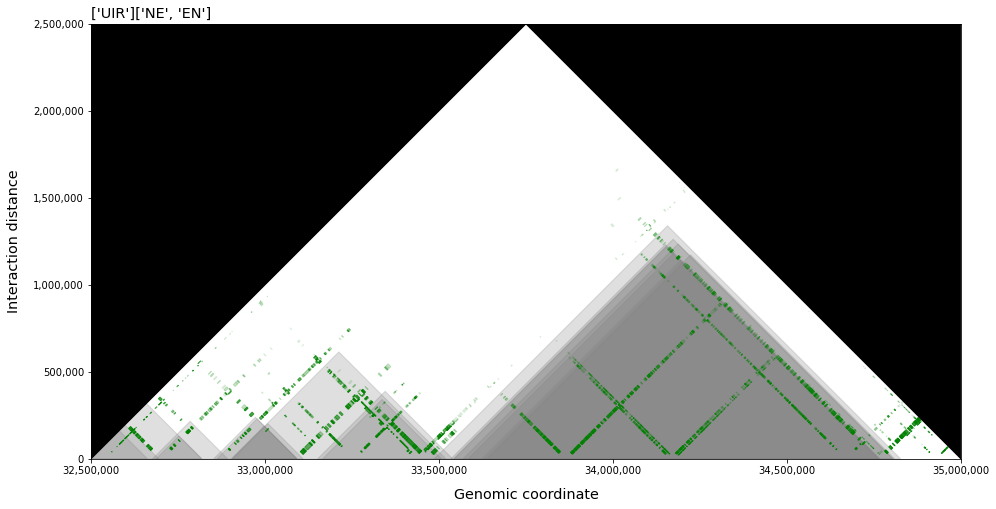

[INFO] Extracted 5245 interactions in range chr1:32500000-35000000
[INFO] Read pair count quantiles:
	[INFO] [ 9. 10. 10. 11. 11. 13. 14. 16. 20. 31.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 32500000 max: 35000000
[INFO] Got 937 interactions
[INFO] begin: 32500000
[INFO] end: 35000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 32500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 35000000.0


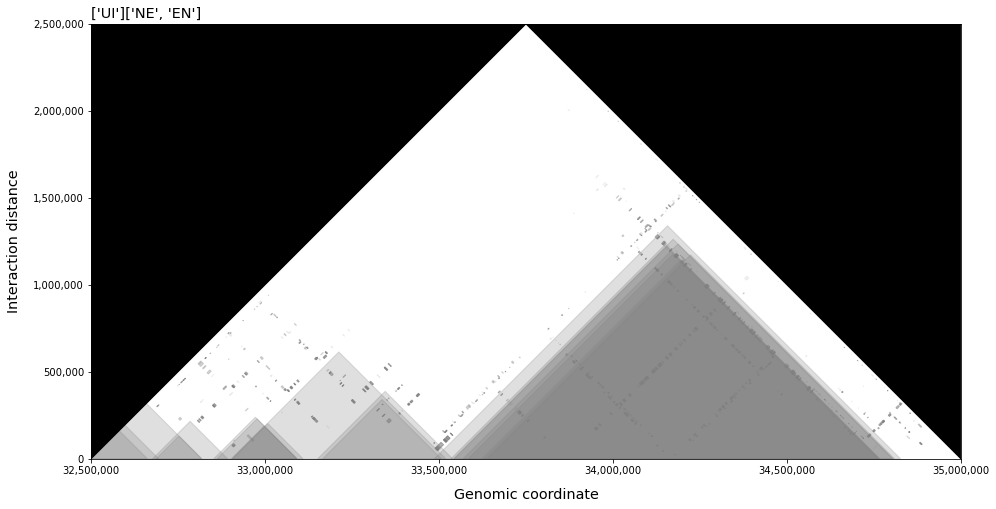

[INFO] Extracted 5490 interactions in range chr1:35000000-37500000
[INFO] Read pair count quantiles:
	[INFO] [ 43.   54.   66.   79.   98.  116.  138.  177.6 248.3 753. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 35000000 max: 37500000
[INFO] Got 678 interactions
[INFO] begin: 35000000
[INFO] end: 37500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 35000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 37500000.0


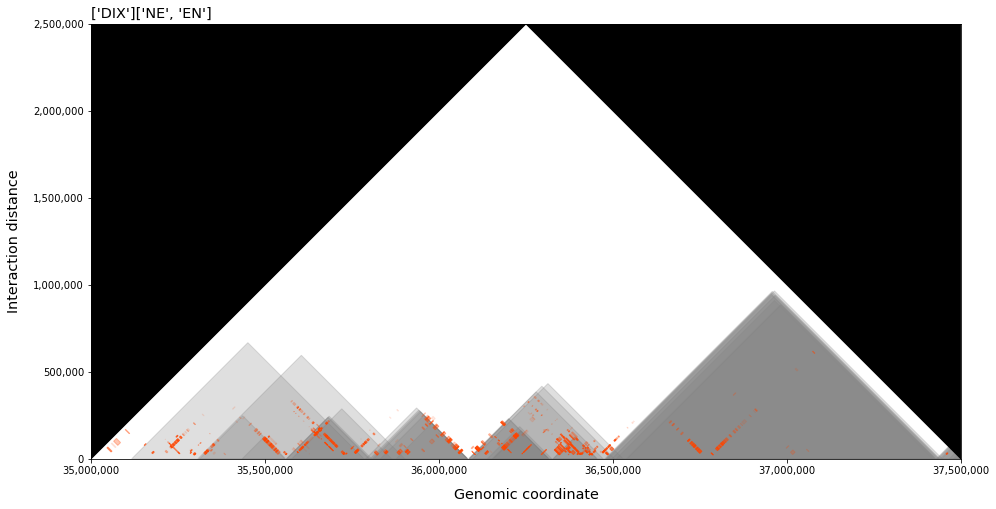

[INFO] Extracted 5490 interactions in range chr1:35000000-37500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  19.  23.  29.  37.  50.  75. 520.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 35000000 max: 37500000
[INFO] Got 2172 interactions
[INFO] begin: 35000000
[INFO] end: 37500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 35000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 37500000.0


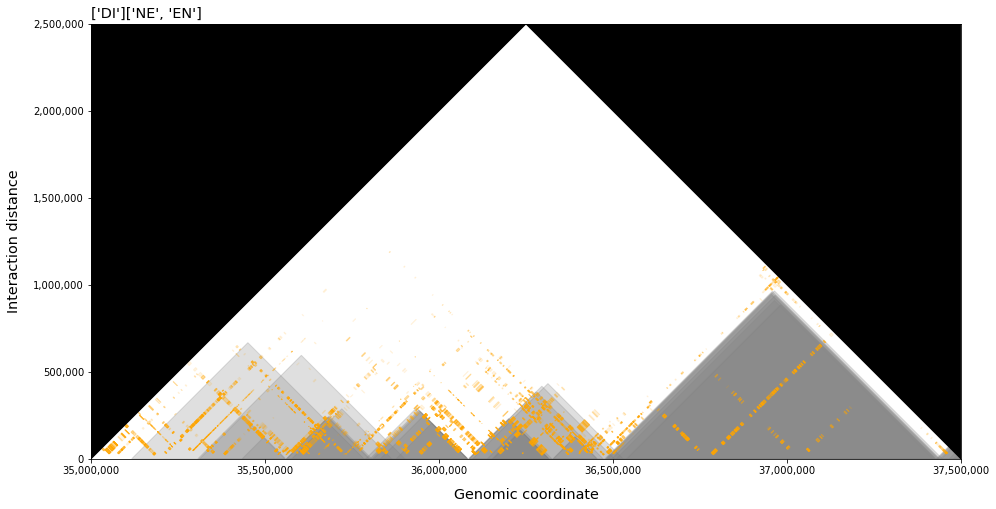

[INFO] Extracted 5490 interactions in range chr1:35000000-37500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  21.  25.  31.  40.  58. 547.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 35000000 max: 37500000
[INFO] Got 1740 interactions
[INFO] begin: 35000000
[INFO] end: 37500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 35000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 37500000.0


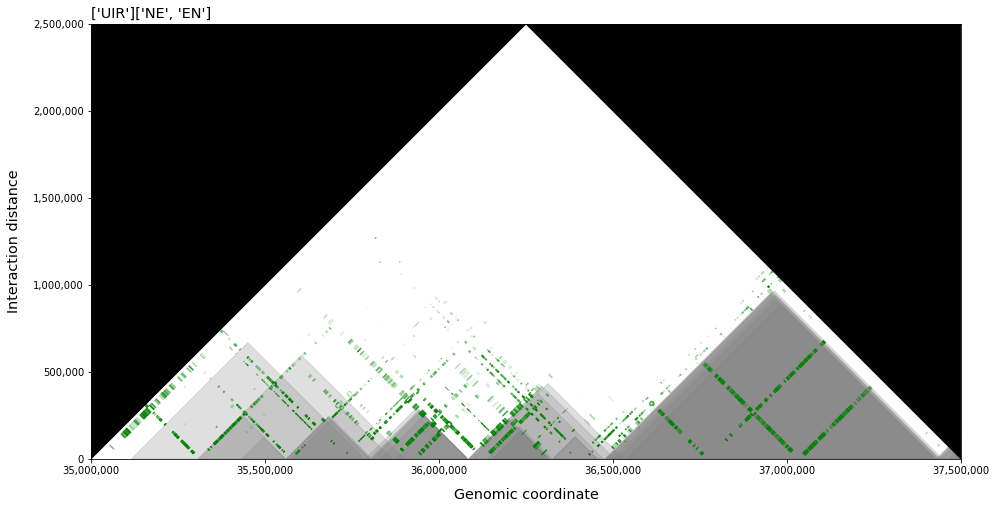

[INFO] Extracted 5490 interactions in range chr1:35000000-37500000
[INFO] Read pair count quantiles:
	[INFO] [ 9. 10. 10. 10. 11. 12. 13. 14. 17. 29.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 35000000 max: 37500000
[INFO] Got 900 interactions
[INFO] begin: 35000000
[INFO] end: 37500000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 35000000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 37500000.0


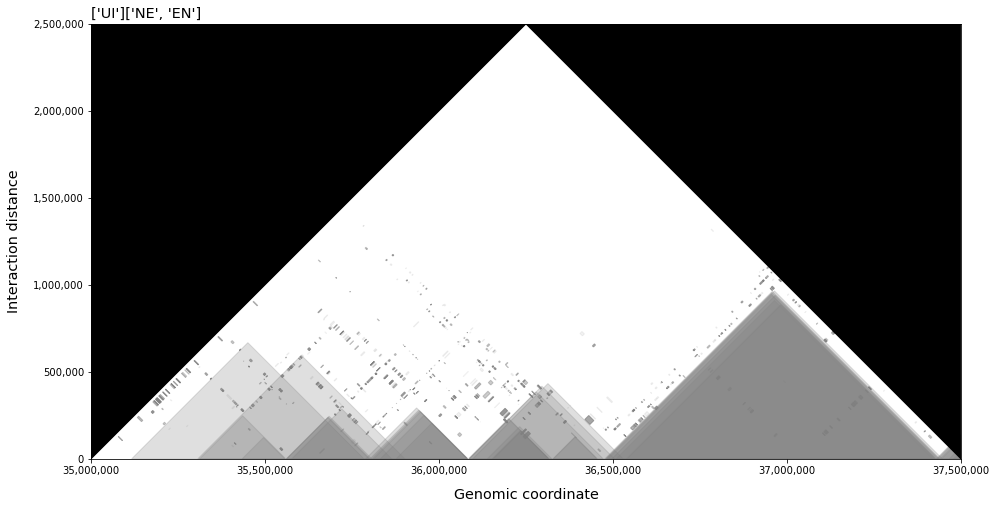

[INFO] Extracted 9188 interactions in range chr1:37500000-40000000
[INFO] Read pair count quantiles:
	[INFO] [ 43.   56.   70.   85.  103.  127.  152.  193.  267.4 847. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 37500000 max: 40000000
[INFO] Got 1143 interactions
[INFO] begin: 37500000
[INFO] end: 40000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 37500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 40000000.0


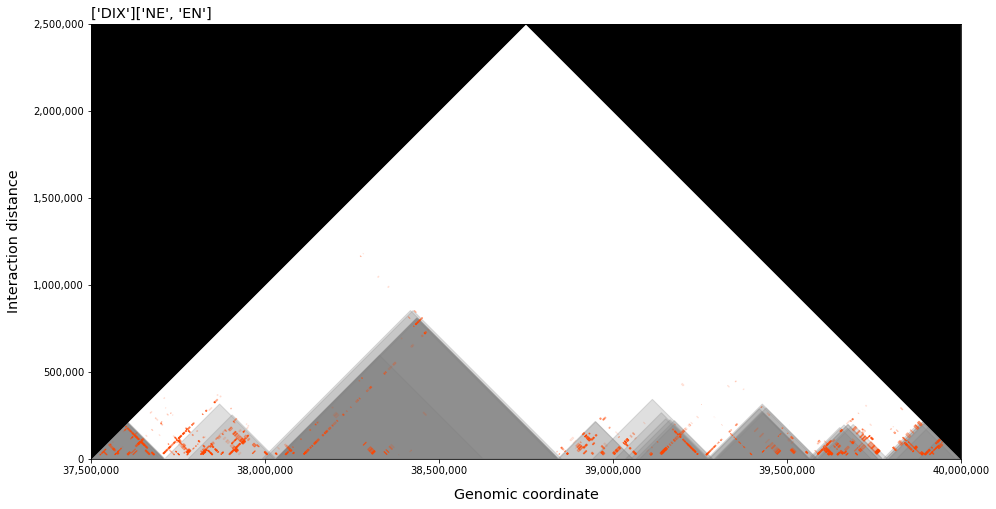

[INFO] Extracted 9188 interactions in range chr1:37500000-40000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  21.  26.  33.  45.  70. 630.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 37500000 max: 40000000
[INFO] Got 3166 interactions
[INFO] begin: 37500000
[INFO] end: 40000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 37500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 40000000.0


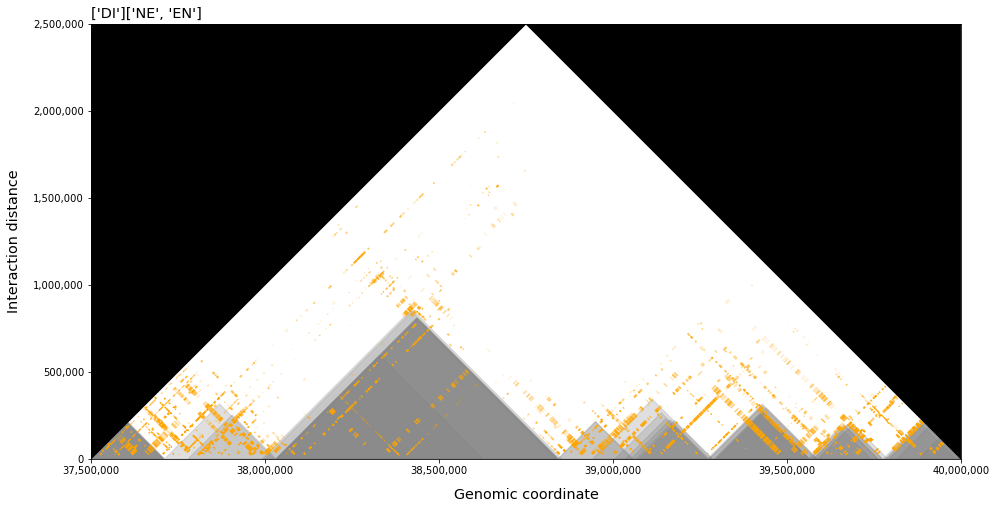

[INFO] Extracted 9188 interactions in range chr1:37500000-40000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  23.  29.  37.  49.  74. 507.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 37500000 max: 40000000
[INFO] Got 3216 interactions
[INFO] begin: 37500000
[INFO] end: 40000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 37500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 40000000.0


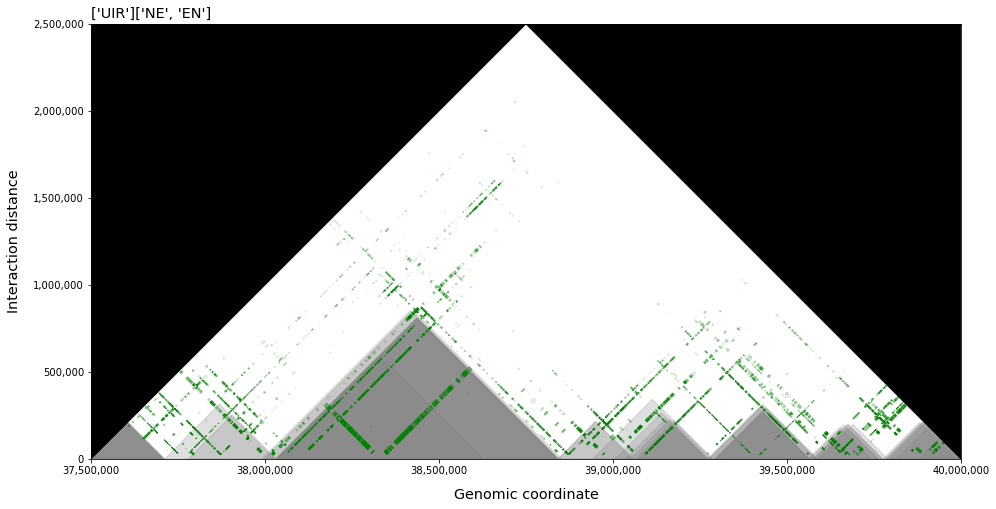

[INFO] Extracted 9188 interactions in range chr1:37500000-40000000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 11. 11. 12. 13. 15. 18. 31.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
4e-06
[INFO] min: 37500000 max: 40000000
[INFO] Got 1663 interactions
[INFO] begin: 37500000
[INFO] end: 40000000
[INFO] pos_to_coordinate(begin): 0.0
[INFO] pos_to_coordinate(end): 10.0
[INFO] coordinate_to_pos(pos_to_coordinate(begin)): 37500000.0
[INFO] coordinate_to_pos(pos_to_coordinate(end)): 40000000.0


KeyboardInterrupt: 

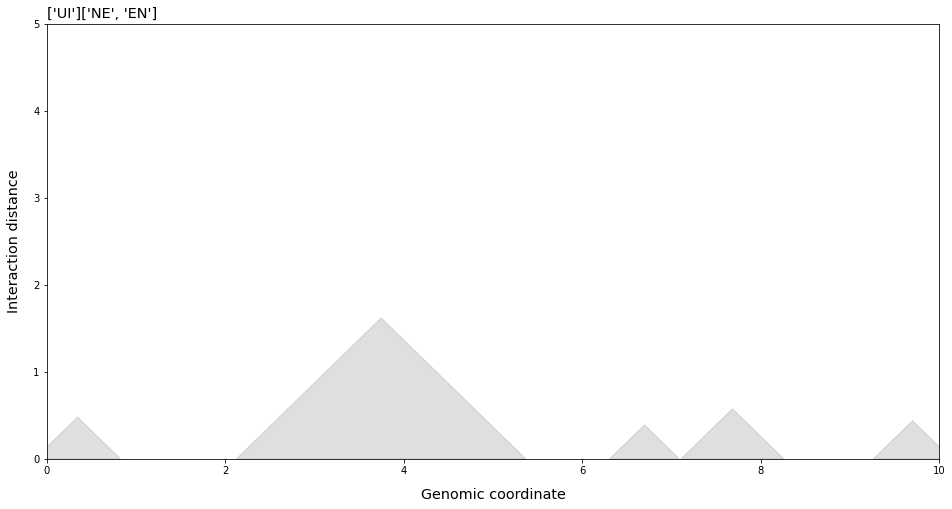

In [43]:
chrom = 'chr1'
for start_pos in range(5000000,50000000,2500000):
    begin = start_pos
    end = begin + 2500000
    visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat_list=['DIX'],
                                enr_cat_list=['NE','EN'])
    visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat_list=['DI'],
                                enr_cat_list=['NE','EN'])
    visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat_list=['UIR'],
                                enr_cat_list=['NE','EN'])
    visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat_list=['UI'],
                                enr_cat_list=['NE','EN'])

In [52]:
visualizer_1 = DirectedTadVisualizer(i_file=INTERACTION_FILE_1, t_file=TAD_BED_FILE)
visualizer_2 = DirectedTadVisualizer(i_file=INTERACTION_FILE_2, t_file=TAD_BED_FILE)

[INFO] Reading cis-interactions and group them by chromosomes ...
	chr1: 598,046 interactions
	chr11: 354,002 interactions
	chr4: 309,656 interactions
	chr6: 363,262 interactions
	chr5: 354,305 interactions
	chr2: 490,432 interactions
	chrX: 154,641 interactions
	chr9: 238,366 interactions
	chr12: 326,426 interactions
	chr10: 265,812 interactions
	chr3: 420,267 interactions
	chr14: 218,642 interactions
	chr13: 155,564 interactions
	chr8: 274,319 interactions
	chr22: 75,687 interactions
	chr19: 114,161 interactions
	chr18: 112,301 interactions
	chr7: 278,988 interactions
	chr16: 130,929 interactions
	chr17: 198,701 interactions
	chr21: 74,629 interactions
	chr20: 140,042 interactions
	chr15: 170,694 interactions
	chrY: 909 interactions
[INFO] ... done.
[INFO] Reading TAD regions and group them by chromosomes ...
	chr1: 2,181 TADs
	chr10: 1,055 TADs
	chr11: 1,244 TADs
	chr12: 1,224 TADs
	chr13: 679 TADs
	chr14: 816 TADs
	chr15: 832 TADs
	chr16: 596 TADs
	chr17: 789 TADs
	chr18: 592 TADs


[INFO] Extracted 9312 interactions in range chr10:5000000-10000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  29.  38.  57. 315.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 5000000 max: 10000000
[INFO] Got 1100 digests
[INFO] Got 3205 interactions
[INFO] begin:5000000
[INFO] end:10000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


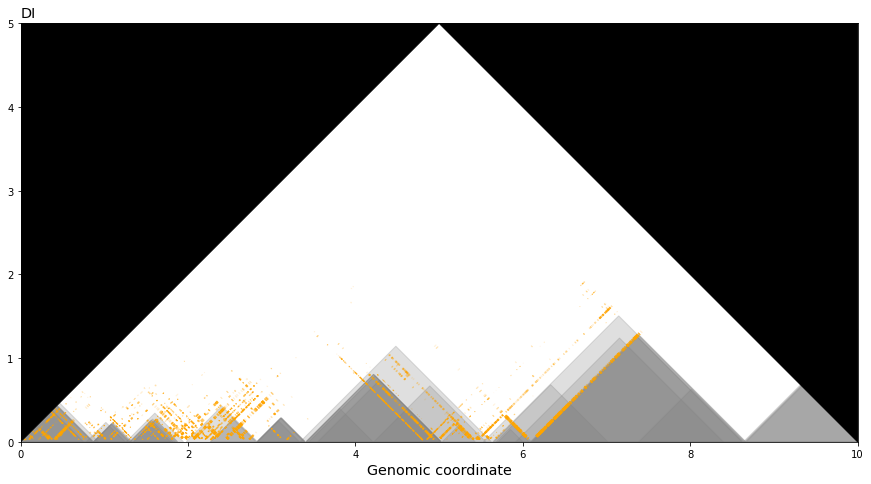

[INFO] Extracted 8572 interactions in range chr10:5000000-10000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  13.  15.  18.  22.  27.  35.  53. 338.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 5000000 max: 10000000
[INFO] Got 978 digests
[INFO] Got 2739 interactions
[INFO] begin:5000000
[INFO] end:10000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


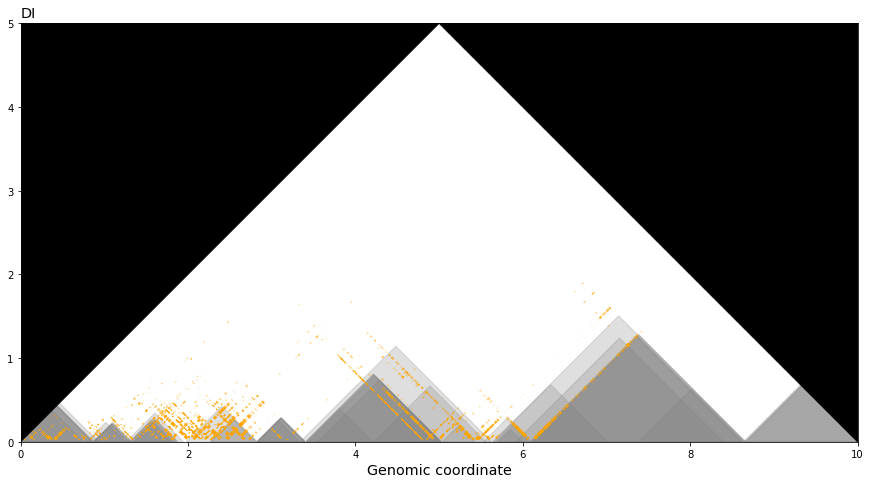

[INFO] Extracted 7749 interactions in range chr10:7500000-12500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  23.  28.  37.  56. 376.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 7500000 max: 12500000
[INFO] Got 1265 digests
[INFO] Got 3589 interactions
[INFO] begin:7500000
[INFO] end:12500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


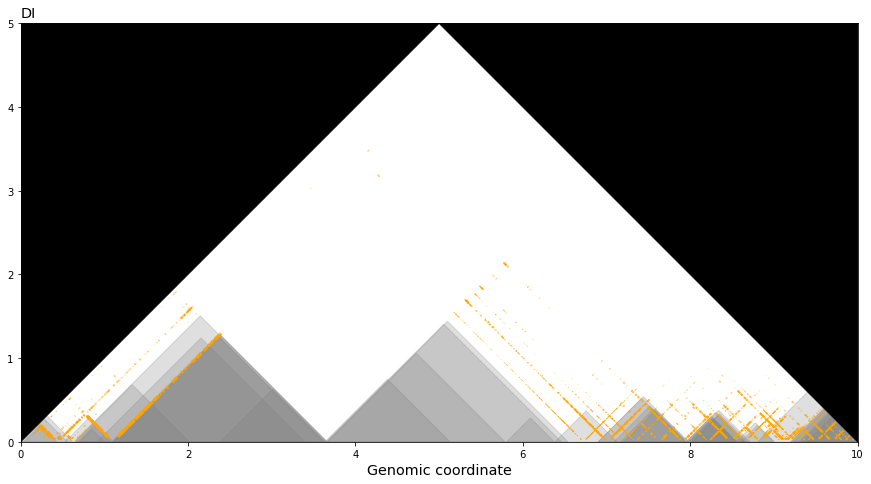

[INFO] Extracted 6078 interactions in range chr10:7500000-12500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  18.  22.  27.  35.  52. 427.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 7500000 max: 12500000
[INFO] Got 963 digests
[INFO] Got 2791 interactions
[INFO] begin:7500000
[INFO] end:12500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


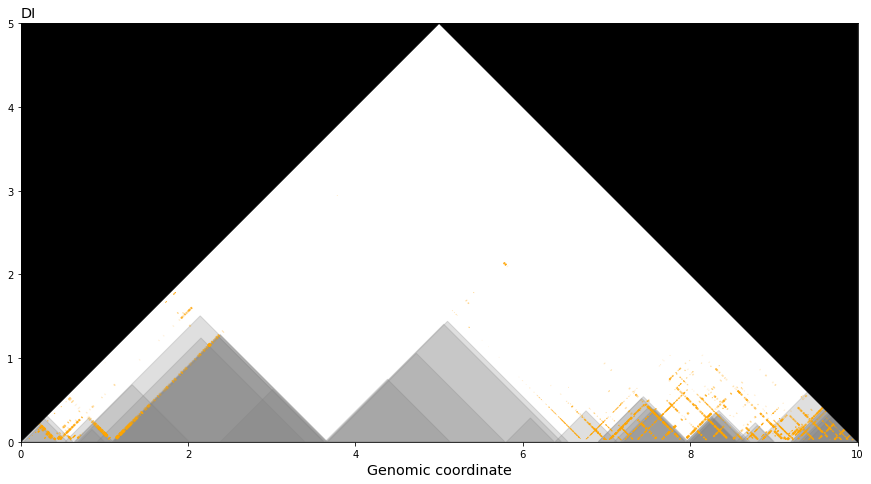

[INFO] Extracted 11832 interactions in range chr10:10000000-15000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  20.  24.  30.  41.  62. 583.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 10000000 max: 15000000
[INFO] Got 1320 digests
[INFO] Got 5391 interactions
[INFO] begin:10000000
[INFO] end:15000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


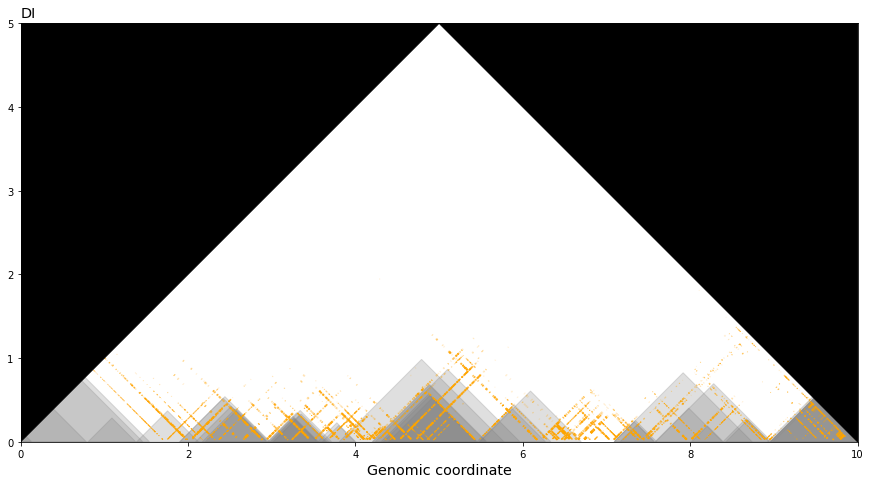

[INFO] Extracted 11821 interactions in range chr10:10000000-15000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  20.  24.  30.  39.  58. 454.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 10000000 max: 15000000
[INFO] Got 1233 digests
[INFO] Got 4932 interactions
[INFO] begin:10000000
[INFO] end:15000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


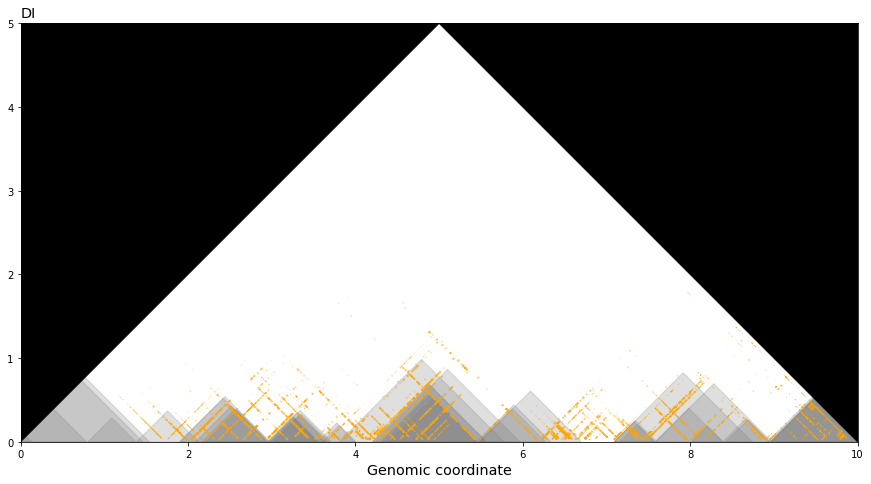

[INFO] Extracted 12622 interactions in range chr10:12500000-17500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  18.  21.  27.  36.  49.  73. 583.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 12500000 max: 17500000
[INFO] Got 1265 digests
[INFO] Got 4266 interactions
[INFO] begin:12500000
[INFO] end:17500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


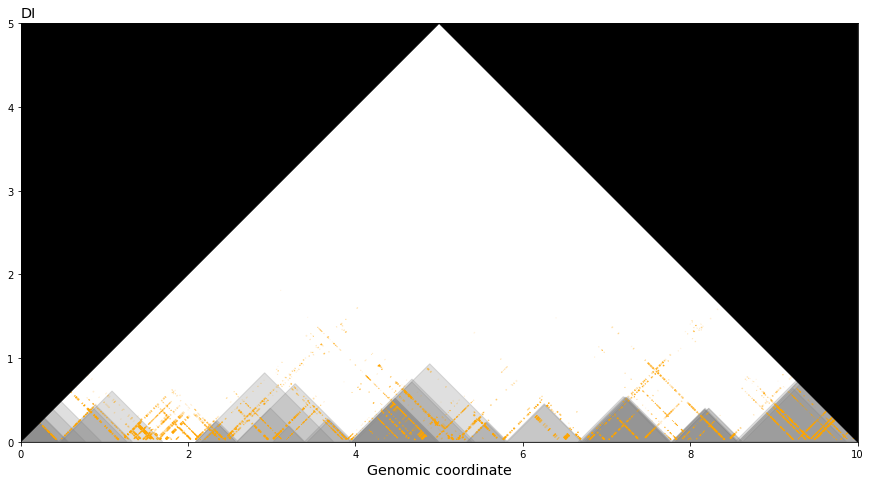

[INFO] Extracted 11430 interactions in range chr10:12500000-17500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  25.  31.  42.  62. 454.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 12500000 max: 17500000
[INFO] Got 1188 digests
[INFO] Got 3851 interactions
[INFO] begin:12500000
[INFO] end:17500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


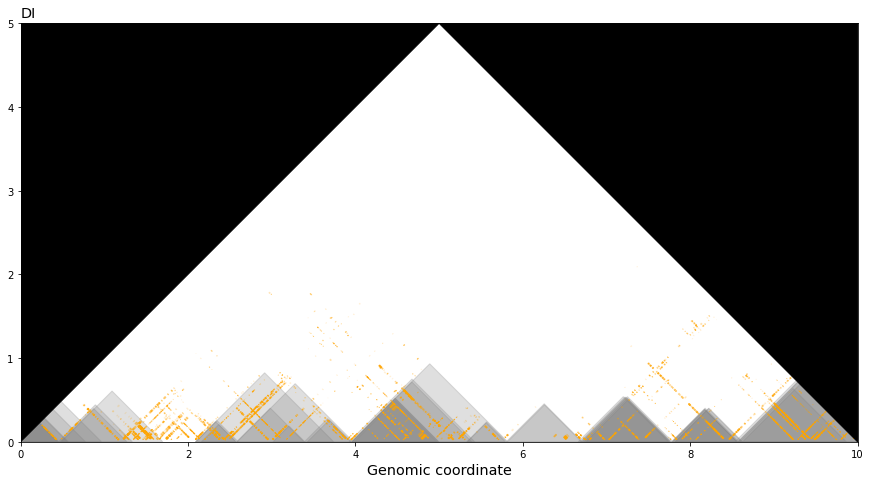

[INFO] Extracted 11238 interactions in range chr10:15000000-20000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  22.  27.  34.  46.  71. 538.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 15000000 max: 20000000
[INFO] Got 1212 digests
[INFO] Got 3584 interactions
[INFO] begin:15000000
[INFO] end:20000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


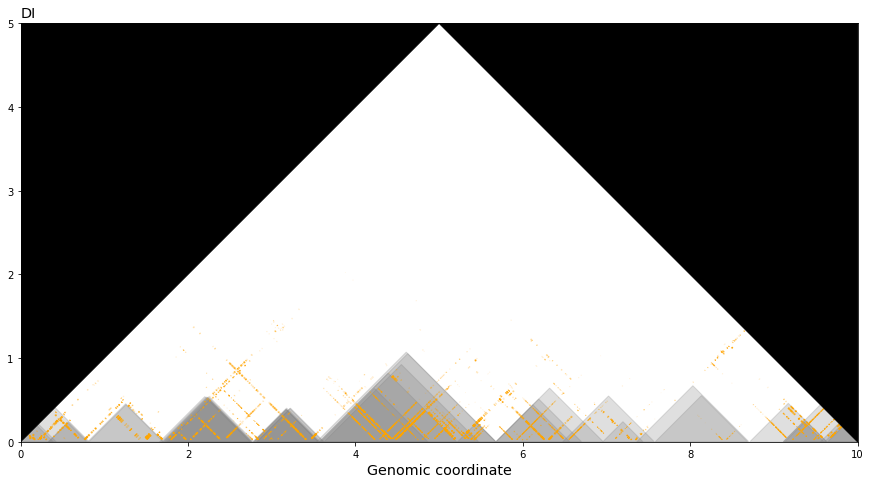

[INFO] Extracted 8775 interactions in range chr10:15000000-20000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  18.  21.  27.  37.  58. 290.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 15000000 max: 20000000
[INFO] Got 1134 digests
[INFO] Got 2889 interactions
[INFO] begin:15000000
[INFO] end:20000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


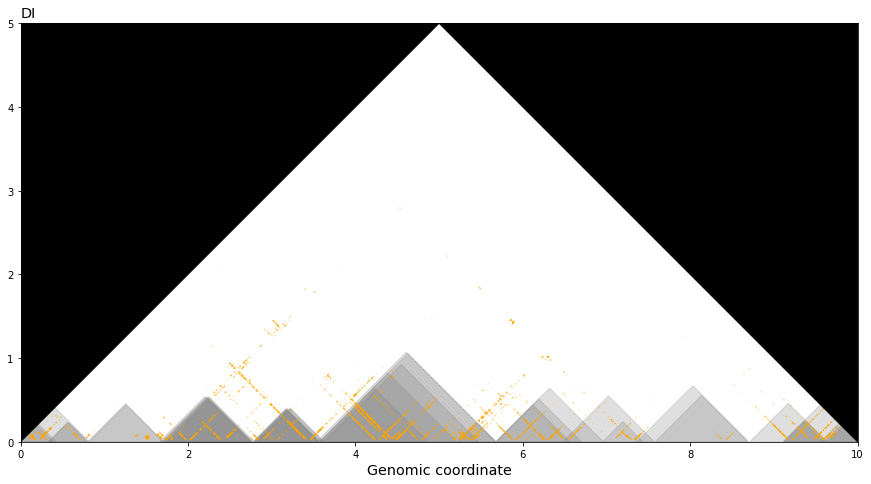

[INFO] Extracted 9159 interactions in range chr10:17500000-22500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  22.  26.  33.  44.  66. 538.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 17500000 max: 22500000
[INFO] Got 1227 digests
[INFO] Got 2736 interactions
[INFO] begin:17500000
[INFO] end:22500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


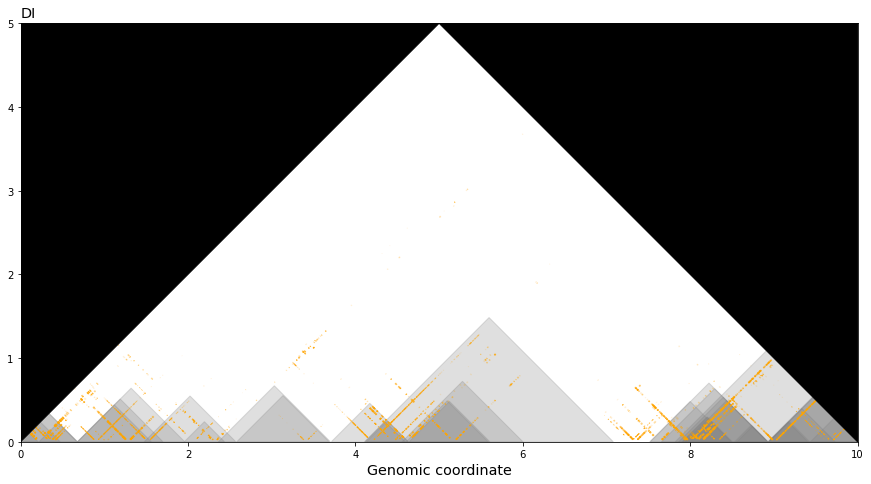

[INFO] Extracted 7351 interactions in range chr10:17500000-22500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  13.  16.  19.  23.  30.  40.  60. 618.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 17500000 max: 22500000
[INFO] Got 1064 digests
[INFO] Got 2293 interactions
[INFO] begin:17500000
[INFO] end:22500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


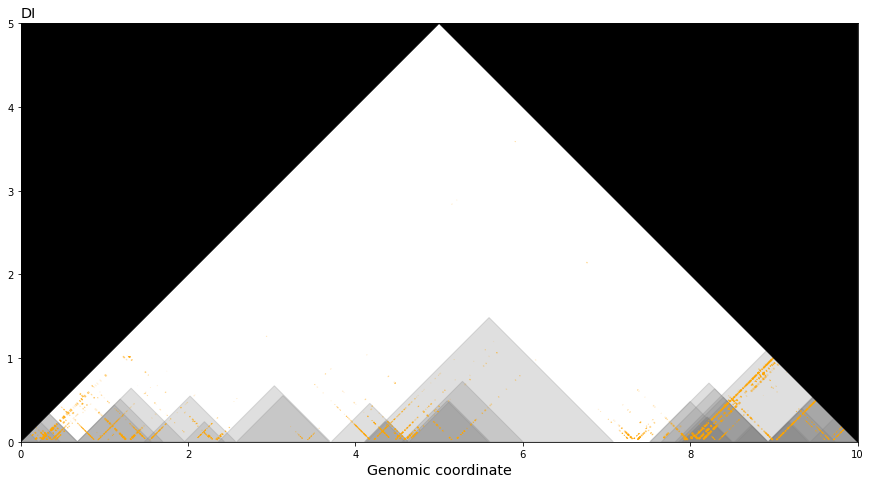

[INFO] Extracted 8612 interactions in range chr10:20000000-25000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  17.  21.  25.  31.  41.  58. 439.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 20000000 max: 25000000
[INFO] Got 1096 digests
[INFO] Got 3433 interactions
[INFO] begin:20000000
[INFO] end:25000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


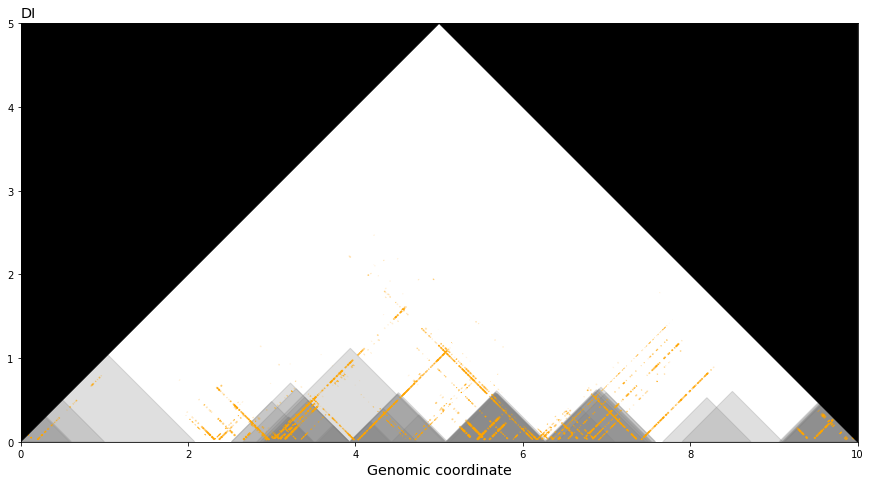

[INFO] Extracted 8724 interactions in range chr10:20000000-25000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  18.  23.  28.  36.  53. 618.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 20000000 max: 25000000
[INFO] Got 1010 digests
[INFO] Got 3392 interactions
[INFO] begin:20000000
[INFO] end:25000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


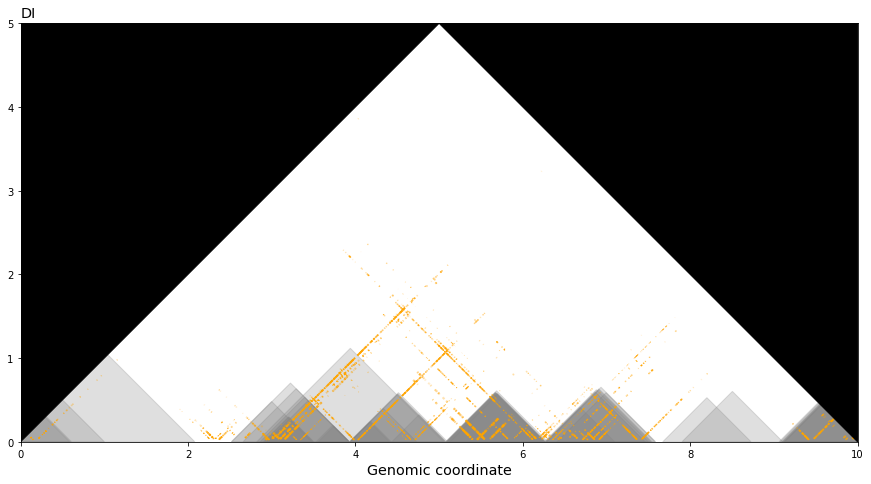

[INFO] Extracted 6993 interactions in range chr10:22500000-27500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.   12.   15.   18.   21.   25.6  31.2  41.   58.  474. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 22500000 max: 27500000
[INFO] Got 1003 digests
[INFO] Got 2477 interactions
[INFO] begin:22500000
[INFO] end:27500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


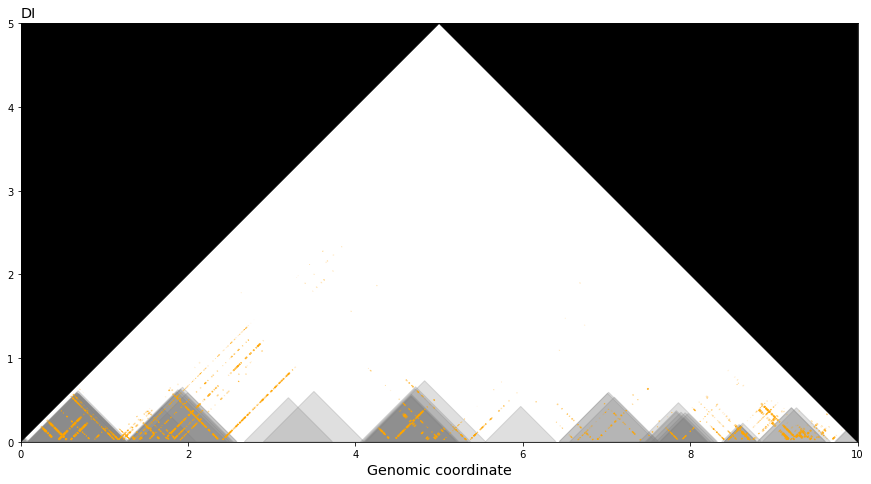

[INFO] Extracted 6291 interactions in range chr10:22500000-27500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  23.  28.  36.  55. 525.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 22500000 max: 27500000
[INFO] Got 958 digests
[INFO] Got 2294 interactions
[INFO] begin:22500000
[INFO] end:27500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


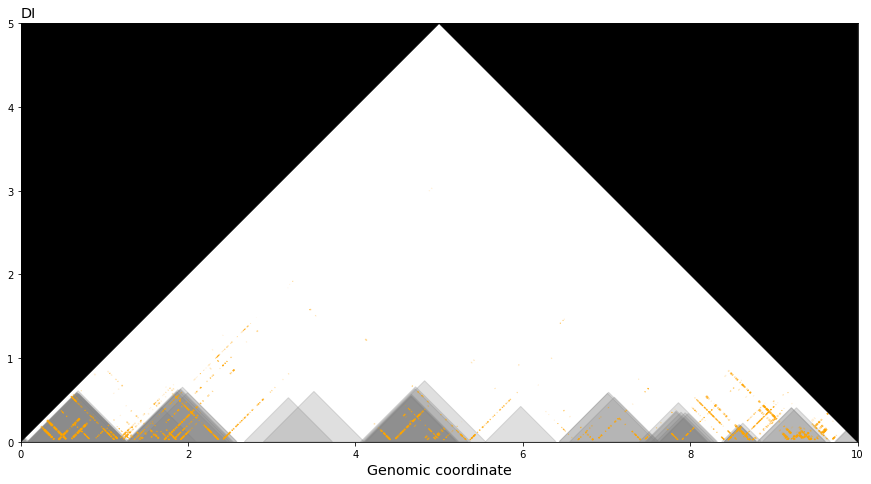

[INFO] Extracted 7180 interactions in range chr10:25000000-30000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  31.  41.  63. 474.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 25000000 max: 30000000
[INFO] Got 1031 digests
[INFO] Got 2409 interactions
[INFO] begin:25000000
[INFO] end:30000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


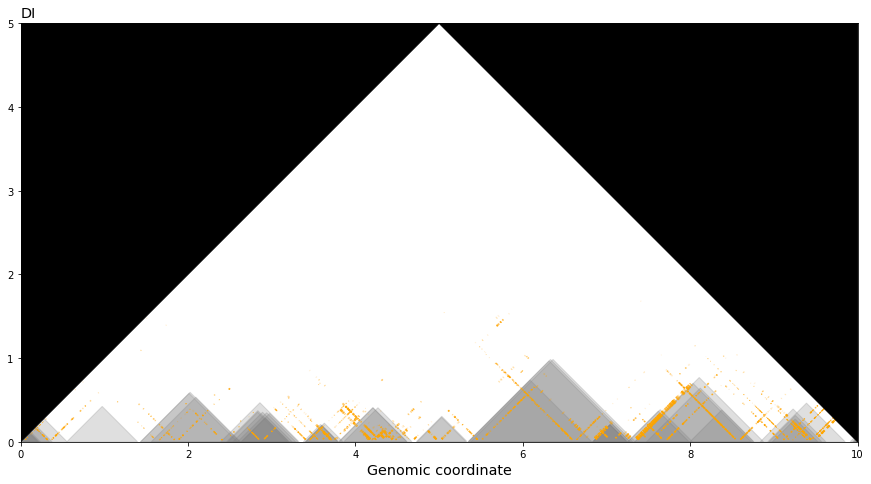

[INFO] Extracted 6222 interactions in range chr10:25000000-30000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  18.  21.  25.  32.  50. 525.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 25000000 max: 30000000
[INFO] Got 948 digests
[INFO] Got 2045 interactions
[INFO] begin:25000000
[INFO] end:30000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


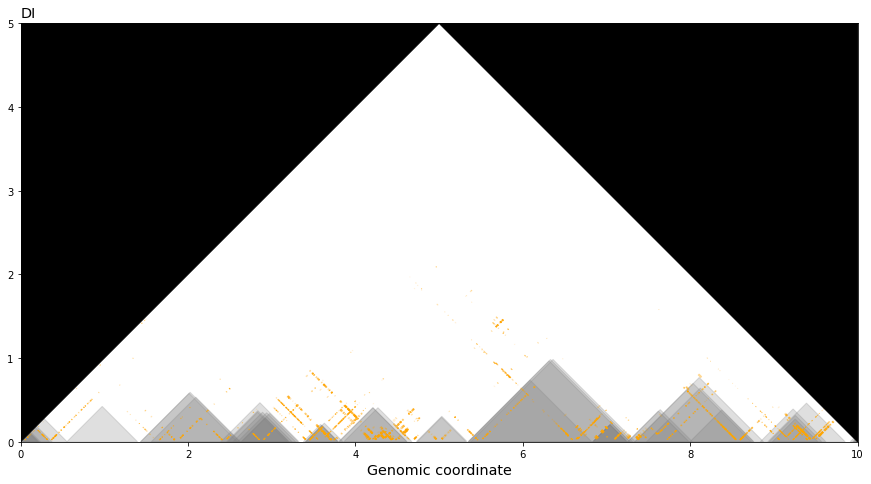

[INFO] Extracted 6627 interactions in range chr10:27500000-32500000
[INFO] Read pair count quantiles:
	[INFO] [ 11.  13.  16.  20.  23.  28.  34.  43.  64. 404.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 27500000 max: 32500000
[INFO] Got 1221 digests
[INFO] Got 2558 interactions
[INFO] begin:27500000
[INFO] end:32500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


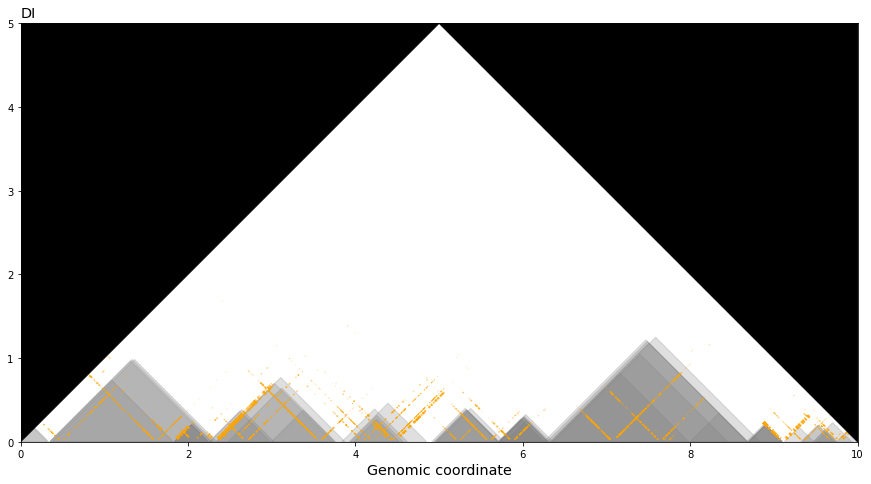

[INFO] Extracted 5146 interactions in range chr10:27500000-32500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  29.  37.  55. 331.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 27500000 max: 32500000
[INFO] Got 1078 digests
[INFO] Got 1828 interactions
[INFO] begin:27500000
[INFO] end:32500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


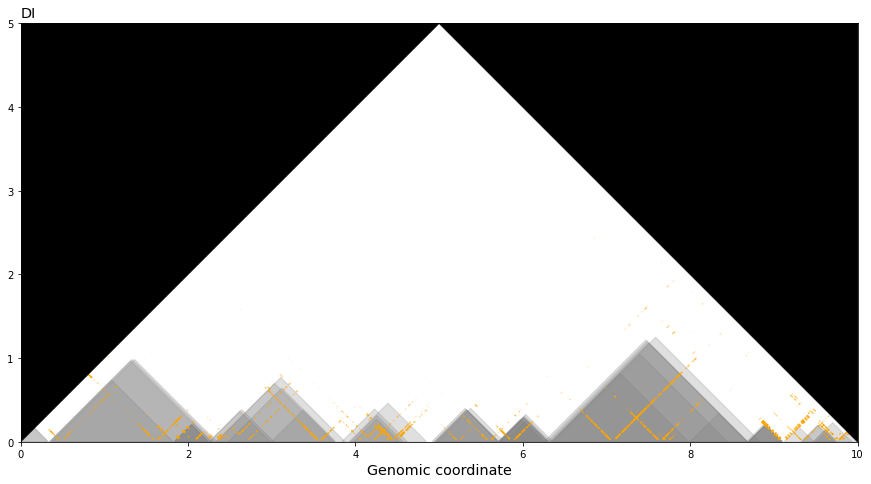

[INFO] Extracted 4859 interactions in range chr10:30000000-35000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  21.  26.  31.  40.  57. 331.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 30000000 max: 35000000
[INFO] Got 1225 digests
[INFO] Got 2158 interactions
[INFO] begin:30000000
[INFO] end:35000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


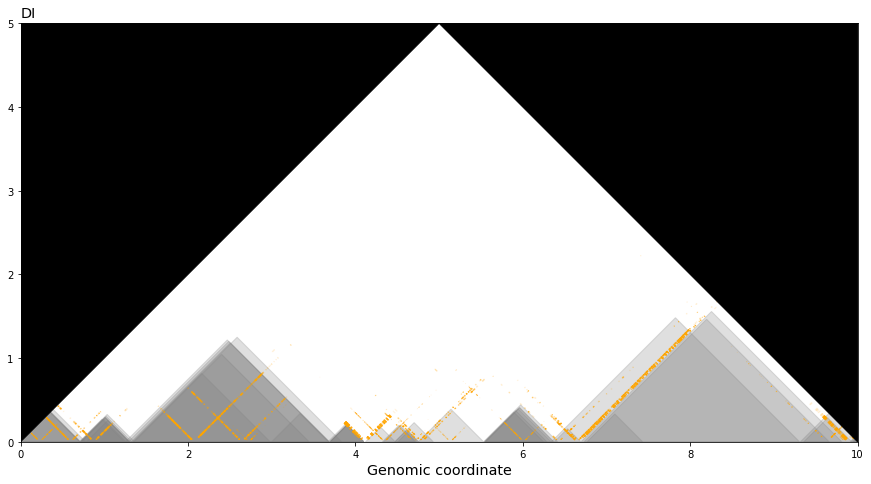

[INFO] Extracted 3841 interactions in range chr10:30000000-35000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  18.  22.  27.  35.  49. 283.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 30000000 max: 35000000
[INFO] Got 898 digests
[INFO] Got 1525 interactions
[INFO] begin:30000000
[INFO] end:35000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


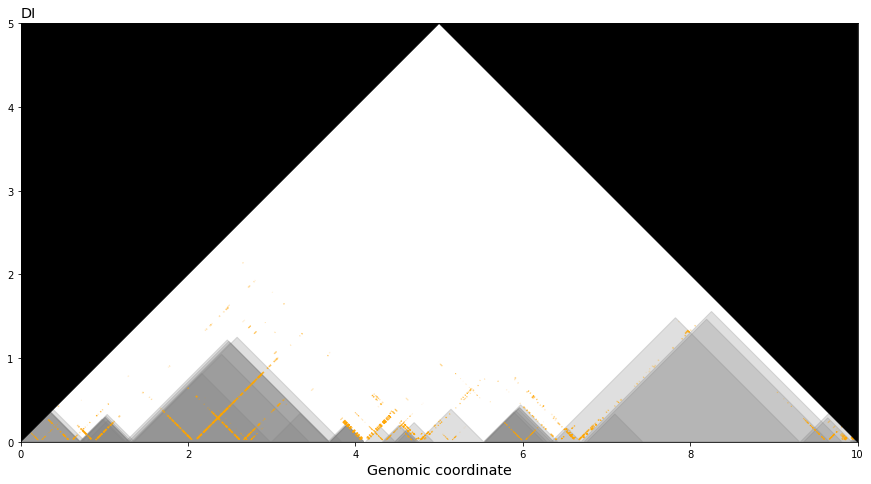

[INFO] Extracted 4636 interactions in range chr10:32500000-37500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  29.  37.  52. 268.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 32500000 max: 37500000
[INFO] Got 965 digests
[INFO] Got 1805 interactions
[INFO] begin:32500000
[INFO] end:37500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


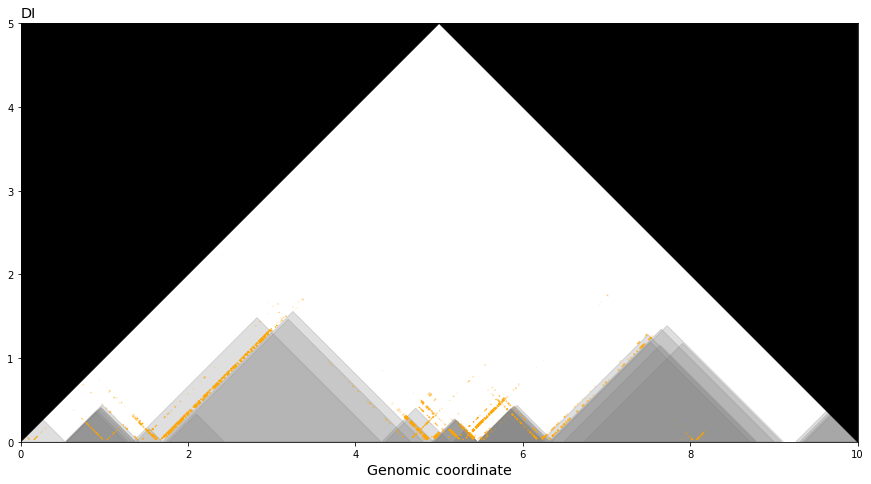

[INFO] Extracted 3149 interactions in range chr10:32500000-37500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  17.  20.  24.  31.  45. 367.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 32500000 max: 37500000
[INFO] Got 661 digests
[INFO] Got 1142 interactions
[INFO] begin:32500000
[INFO] end:37500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


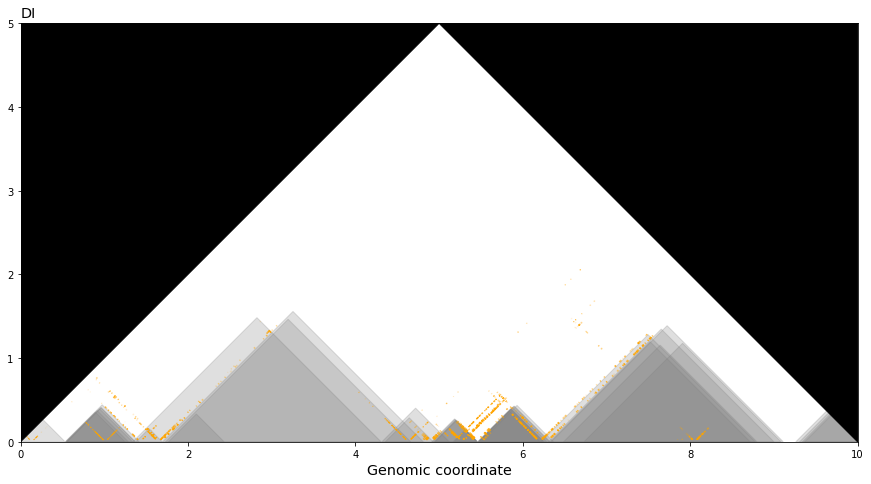

[INFO] Extracted 1713 interactions in range chr10:35000000-40000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  17.  21.  25.  31.  44. 213.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 35000000 max: 40000000
[INFO] Got 487 digests
[INFO] Got 815 interactions
[INFO] begin:35000000
[INFO] end:40000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


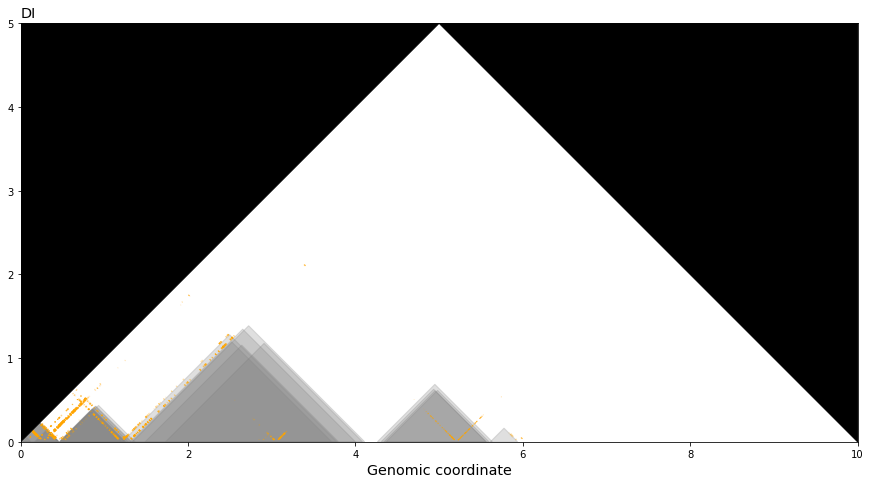

[INFO] Extracted 1793 interactions in range chr10:35000000-40000000
[INFO] Read pair count quantiles:
	[INFO] [  9.9  11.   12.7  14.   16.   19.   23.   29.   40.1 367. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 35000000 max: 40000000
[INFO] Got 459 digests
[INFO] Got 780 interactions
[INFO] begin:35000000
[INFO] end:40000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


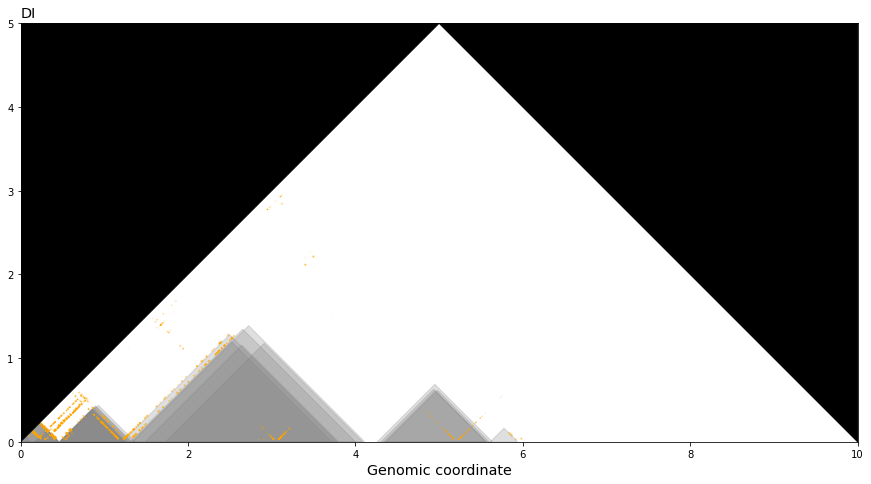

[INFO] Extracted 126 interactions in range chr10:37500000-42500000
[INFO] Read pair count quantiles:
	[INFO] [ 9.  11.  13.  14.  16.  18.  20.  24.  31.2 62. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 37500000 max: 42500000
[INFO] Got 95 digests
[INFO] Got 98 interactions
[INFO] begin:37500000
[INFO] end:42500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


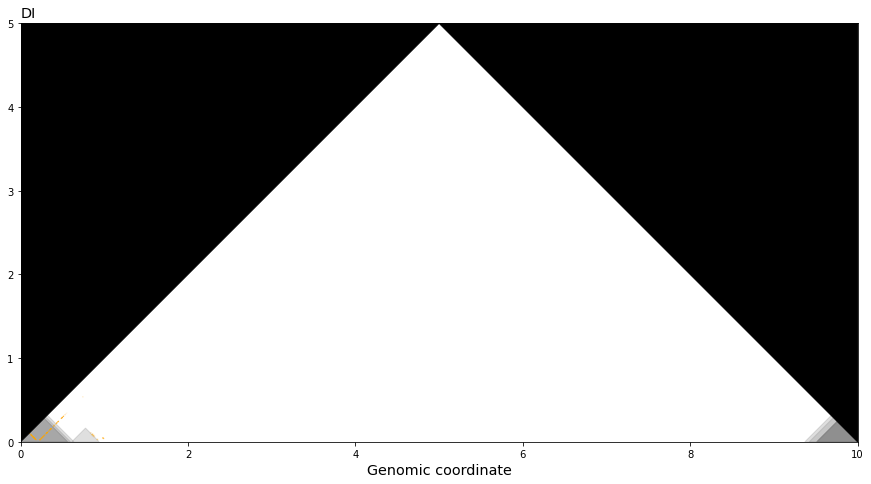

[INFO] Extracted 114 interactions in range chr10:37500000-42500000
[INFO] Read pair count quantiles:
	[INFO] [10.  11.  12.  14.  15.  17.  20.5 24.  34.  77. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 37500000 max: 42500000
[INFO] Got 78 digests
[INFO] Got 76 interactions
[INFO] begin:37500000
[INFO] end:42500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


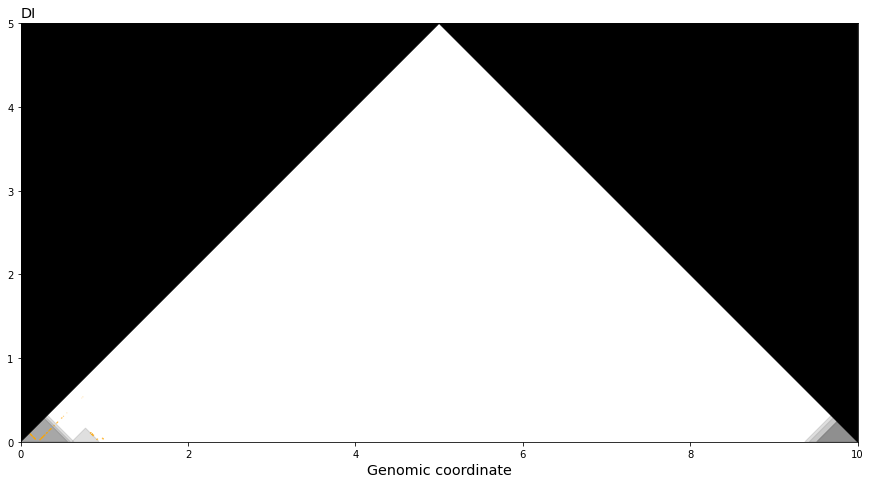

[INFO] Extracted 4340 interactions in range chr10:40000000-45000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  22.  28.  34.  48. 371.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 40000000 max: 45000000
[INFO] Got 598 digests
[INFO] Got 2225 interactions
[INFO] begin:40000000
[INFO] end:45000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


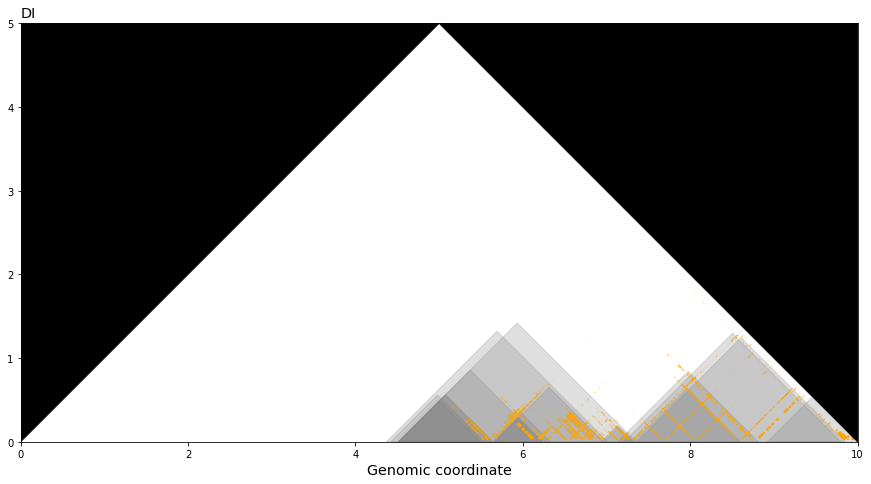

[INFO] Extracted 3108 interactions in range chr10:40000000-45000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  11.  13.  15.  16.  19.  22.  26.  36. 244.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 40000000 max: 45000000
[INFO] Got 561 digests
[INFO] Got 1652 interactions
[INFO] begin:40000000
[INFO] end:45000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


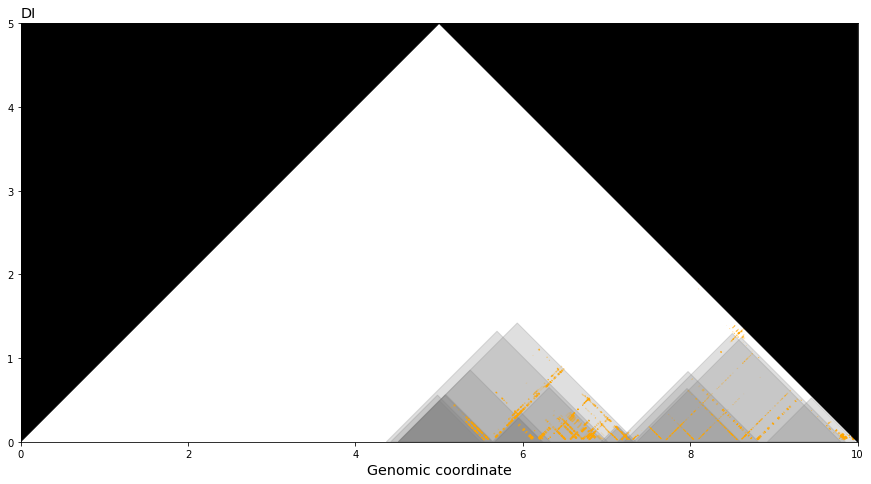

[INFO] Extracted 6608 interactions in range chr10:42500000-47500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  22.  27.  34.  48. 371.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 42500000 max: 47500000
[INFO] Got 868 digests
[INFO] Got 3021 interactions
[INFO] begin:42500000
[INFO] end:47500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


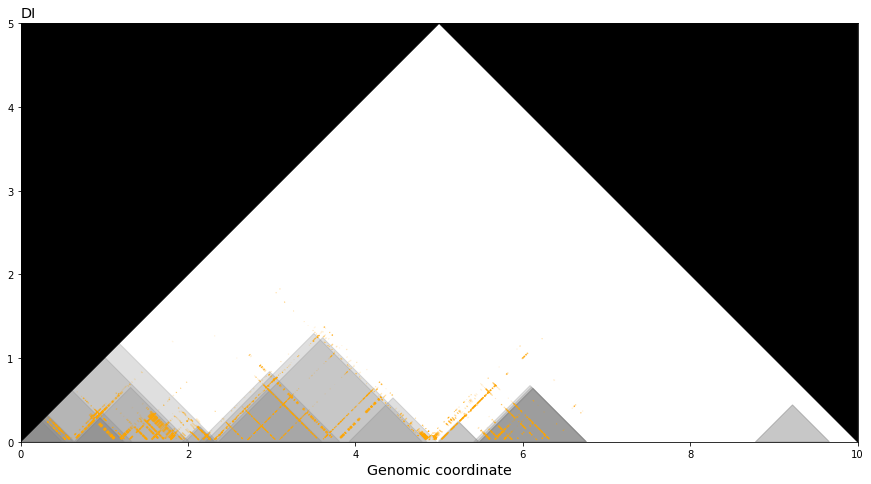

[INFO] Extracted 4946 interactions in range chr10:42500000-47500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.   12.   13.   15.   17.   20.   23.   28.   38.7 244. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 42500000 max: 47500000
[INFO] Got 817 digests
[INFO] Got 2274 interactions
[INFO] begin:42500000
[INFO] end:47500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


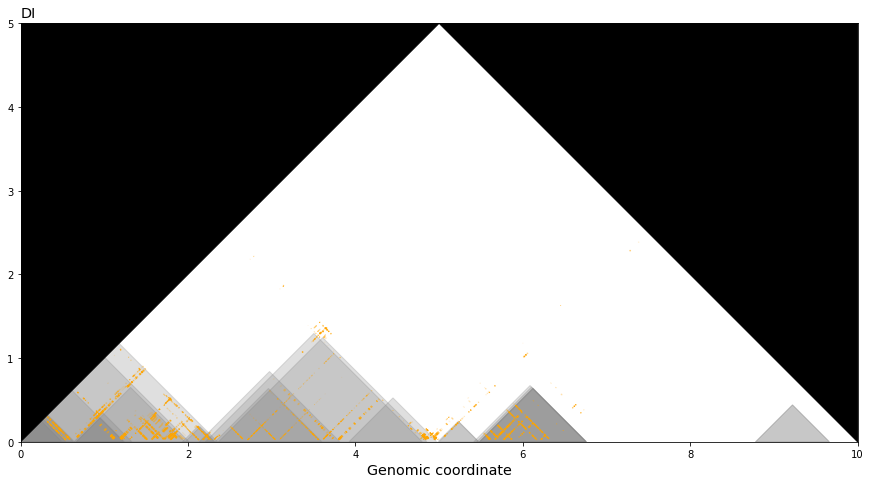

[INFO] Extracted 5997 interactions in range chr10:45000000-50000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  29.  36.  52. 211.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 45000000 max: 50000000
[INFO] Got 656 digests
[INFO] Got 2670 interactions
[INFO] begin:45000000
[INFO] end:50000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


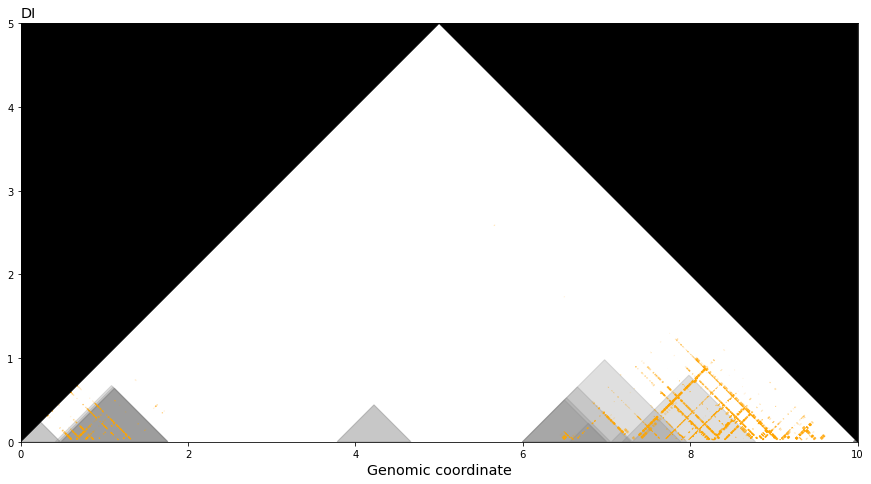

[INFO] Extracted 5261 interactions in range chr10:45000000-50000000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  18.  21.  25.  32.  47. 367.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 45000000 max: 50000000
[INFO] Got 617 digests
[INFO] Got 2101 interactions
[INFO] begin:45000000
[INFO] end:50000000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


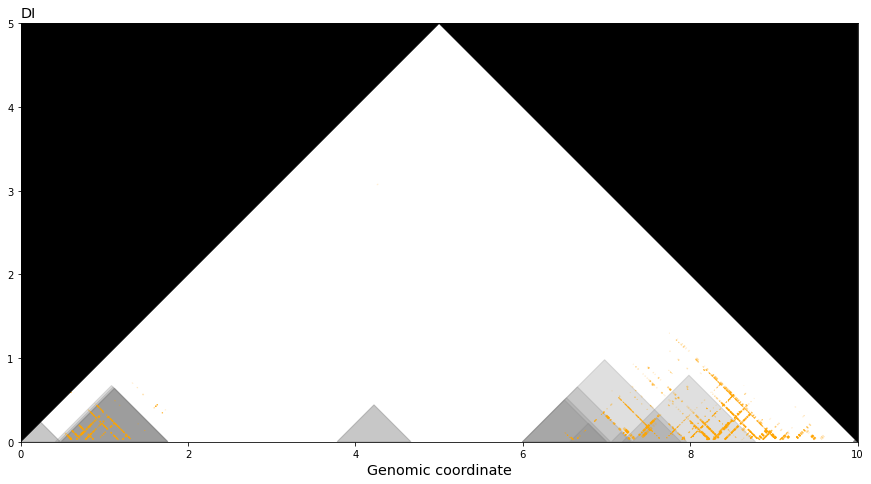

[INFO] Extracted 8092 interactions in range chr10:47500000-52500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  19.  22.  27.  33.  43.  63. 275.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 47500000 max: 52500000
[INFO] Got 891 digests
[INFO] Got 3069 interactions
[INFO] begin:47500000
[INFO] end:52500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


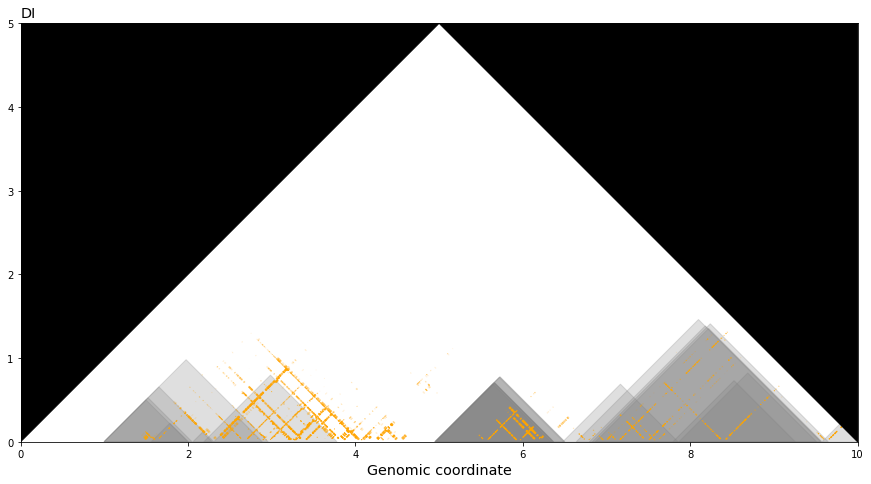

[INFO] Extracted 7124 interactions in range chr10:47500000-52500000
[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  23.  28.  37.  53. 367.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5000000
[INFO] min: 47500000 max: 52500000
[INFO] Got 811 digests
[INFO] Got 2325 interactions
[INFO] begin:47500000
[INFO] end:52500000
[INFO] pos_to_coordinate(begin):0.0
[INFO] pos_to_coordinate(end):10.0


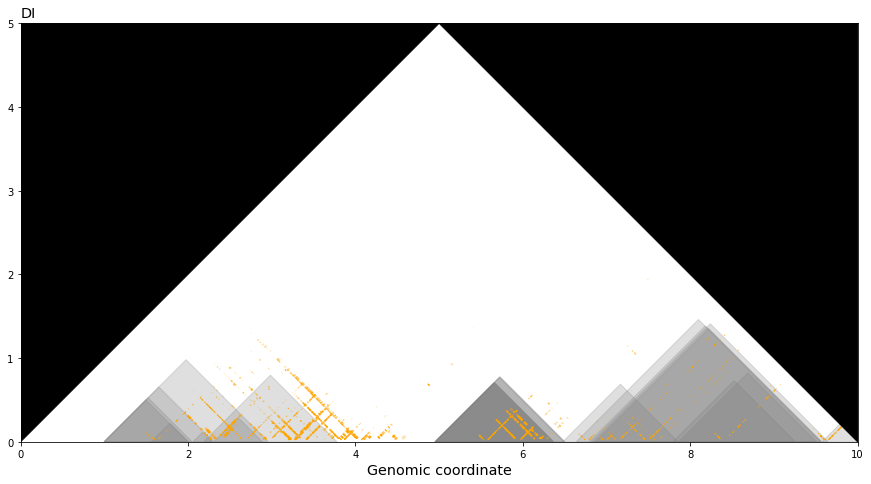

In [57]:
chrom = 'chr10'
for start_pos in range(5000000,50000000,2500000):
    begin = start_pos
    end = begin + 5000000
    inter_dict_1 = visualizer_1.extract_interactions(chrom=chrom, begin=begin, end=end)
    visualizer_1.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='DI',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict_1)
    inter_dict_2 = visualizer_2.extract_interactions(chrom=chrom, begin=begin, end=end)
    visualizer_2.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='DI',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict_2)

In [20]:
digest_set = set()
interaction_list = []
with open('dtadvis-out.tsv') as f:
    for line in f:
        fields = line.rstrip().split('\t')
        digestA = Digest(chrom=fields[0], begin=int(fields[1]), end=int(fields[2]))
        digestB = Digest(chrom=fields[4], begin=int(fields[5]), end=int(fields[6]))
        digest_set.add(digestA)
        digest_set.add(digestB)
        statusA = fields[3] # N or E for digest A
        statusB = fields[7] # N or E for digest B
        ST = fields[8] # e.g., 2:3:1:5, read pair counts
        icat = fields[10] # interaction category, e.g. DIX, DI, etc.
        ia = Interaction(digestA=digestA, digestB=digestB, statusA=statusA, statusB=statusB, ST=ST, icat=icat)
        interaction_list.append(ia)

In [30]:
digest_list = list(digest_set)
digest_list.sort(key=lambda x: x.begin, reverse=False)
digest_min = min([x.begin for x in digest_list])
digest_max = max([x.end for x in digest_list])
digest_span = digest_max - digest_min
_factor = visualizer._figure_size / digest_span
print("[INFO] min: {} max: {}".format(_min, digest_min))
digest_to_coords = defaultdict(list)
for d in digest_list:
    digest_to_coords[d] = visualizer.digest_to_coordinates(d)
print("[INFO] Got {} digests".format(len(digest_set)))
print("[INFO] Got {} interactions".format(len(interaction_list)))

NameError: name 'digest_set' is not defined

AttributeError: 'DirectedTadVisualizer' object has no attribute '_min'

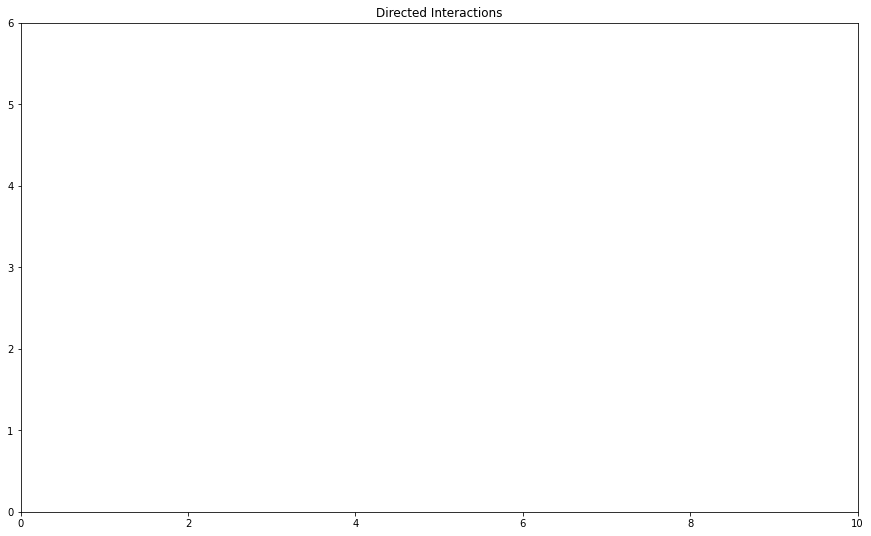

In [22]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)

ax.set_title('Directed Interactions')
xrange = [0, 10]
yrange = [0, 6]
ax.set_xlim(xrange)
ax.set_ylim(yrange)
xticks_new = []
for ia in interaction_list:
    polypatch = visualizer.interaction_to_polygon(interaction=ia, digest_to_coords=digest_to_coords)
    ax.add_patch(polypatch)
    pos = 0.5*(ia._min + ia._max) / 1000
    xticks_new.append(str(int(pos)) + ' kb')
ax.set_xticklabels(xticks_new)
        # ax.set_ylim(*yrange)
        # ax.set_yticks(range(*yrange) + [yrange[-1]])
ax.set_aspect(1)
plt.show()

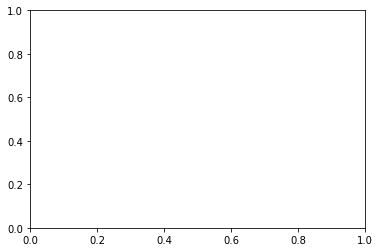

In [13]:

# return locs, labels where locs is an array of tick locations and
# labels is an array of tick labels.
locs, labels = plt.xticks()

In [14]:
labels
chrt=['a','b', 'c','d', 'e']
new_labels = [x.set_text(chrt[i]) for i,x  in enumerate(labels)]

IndexError: list index out of range

In [15]:
t = labels[0]

matplotlib.text.Text

In [16]:
t.get_text()

'a'

In [17]:
t.set_text("chr1 50kb")

In [44]:
t

Text(0.0, 0, 'chr1 50kb')